## Распознавание эмоций по тексту

Датасет был найден на сайте Kaggle. Ссылка на датасет - https://www.kaggle.com/datasets/shreejitcheela/text-emotion-recognition

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

import warnings

import optuna

from tqdm import tqdm

from wordcloud import WordCloud

import re

import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegressionCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import recall_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from catboost import CatBoostClassifier

from sklearn.model_selection import train_test_split

import pickle

from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.metrics import  recall_score

from IPython.utils import io

## Загрузка датасета

In [254]:
full_data_path = fr"C:\projects\Python\ML\DataBases\text_emotions\Text_Emotion.csv"

In [255]:
full_df = pd.read_csv(full_data_path)
full_df

,text,emotion
0,carefully word blog posts amount criticism hea...,☹️
1,cannot remember little mermaid feeling carefre...,🙂
2,not feeling super well turns cold knocked next...,🙂
3,feel honored part group amazing talents,🙂
4,think helping also began feel pretty lonely lo...,☹️
...,...,...
282817,feel honored motivated share world life changi...,🙂
282818,feel like gloaty really delighted,🙂
282819,feel little energetic one day next several day...,🙂
282820,feel work experience fell although fantastic o...,🙂


In [256]:
full_df[full_df.loc[:, ['emotion']] == '☹️'] = 0
full_df[full_df.loc[:, ['emotion']] == '🙂'] = 1

In [257]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 282822 entries, 0 to 282821
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   text     282822 non-null  object
 1   emotion  282822 non-null  object
dtypes: object(2)
memory usage: 4.3+ MB


In [258]:
full_df.emotion = full_df.emotion.astype('Int8')

In [259]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 282822 entries, 0 to 282821
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   text     282822 non-null  object
 1   emotion  282822 non-null  Int8  
dtypes: Int8(1), object(1)
memory usage: 2.7+ MB


In [261]:
full_df.isna().sum()  # нет Nan значений, что было показано при выводе info

text       0
emotion    0
dtype: int64

In [19]:
# примеры текста отрицательных эмоций
for true_value in full_df[full_df.emotion == 0]['text'].head(5):
    print(true_value)

carefully word blog posts amount criticism hear place coming saudis non saudis goes show feeling discontent lot areas directed towards specific people never swat teams charging conversations
think helping also began feel pretty lonely lot people used enjoy climbing moved really feel like anyone climb hard gym anymore
still feeling exhausted know strength gotten day
feeling extremely ugly right
waiting sun come back school called joey sore throat want summer make lunch love alllllllllllll


In [20]:
# примеры текста положительных эмоций
for true_value in full_df[full_df.emotion == 1]['text'].head(5):
    print(true_value)

cannot remember little mermaid feeling carefree beauty life gets lost somewhere massive piles homework budgeting finances eventually daunting choices life become adult
not feeling super well turns cold knocked next three weeks afterward hotter know head not
feel honored part group amazing talents
feel like pleasant nice around
cannot get feelings not trusting head


Предложения не похожи на написанные человеком. Они не являются полноценными. Слова идут обрывками и полный смысл предложения не понятен.

### Гипотеза: текст уже был предобработан

In [21]:
def remove_punctuation(text):
    return "".join([ch if ch not in string.punctuation else ' ' for ch in text])

def remove_numbers(text):
    return ''.join([i if not i.isdigit() else ' ' for i in text])

def remove_multiple_spaces(text):
  """удаление специальных символов"""
  return re.sub(r'\s+', ' ', text, flags=re.I)

In [22]:
english_stop_words = stopwords.words('english')
snowball = SnowballStemmer(language='english')

def tokenize_sentence(sentence: str, remove_stop_words: bool = True):
    prep_text = [remove_multiple_spaces(remove_numbers(remove_punctuation(sentence.lower())))]
    prep_text = ' '.join(prep_text)
    
    tokens = word_tokenize(prep_text, language = 'english')
    if remove_stop_words:
        tokens = [i for i in tokens if i not in english_stop_words]
    tokens = [snowball.stem(i) for i in tokens]
    return tokens

In [23]:
for true_value in full_df[full_df.emotion == 1]['text'].head(10):
    print(len(true_value.split()), len(tokenize_sentence(true_value)))

22 21
15 13
6 6
5 5
6 4
5 4
5 5
10 9
5 5
19 18


до обработки

In [24]:
text_length = full_df.text.apply(len).to_list()  # длины строк с текстом
text_word_amout = []  # количество слов в тексте (важно, тк при обработке происходит еще и стемминг)
for i in full_df.text:
    text_word_amout += [len(i.split())]

обработка

In [25]:
english_stopwords = stopwords.words("english")

In [26]:
prep_texts = []
for t in tqdm(full_df.text):
    prep_texts.append(' '.join(tokenize_sentence(t)))

100%|██████████| 282822/282822 [00:28<00:00, 10100.06it/s]


после обработки

In [27]:
full_df['prep_text'] = prep_texts
full_df

,text,emotion,prep_text
0,carefully word blog posts amount criticism hea...,0,care word blog post amount critic hear place c...
1,cannot remember little mermaid feeling carefre...,1,rememb littl mermaid feel carefre beauti life ...
2,not feeling super well turns cold knocked next...,1,feel super well turn cold knock next three wee...
3,feel honored part group amazing talents,1,feel honor part group amaz talent
4,think helping also began feel pretty lonely lo...,0,think help also began feel pretti lone lot peo...
...,...,...,...
282817,feel honored motivated share world life changi...,1,feel honor motiv share world life chang gift a...
282818,feel like gloaty really delighted,1,feel like gloati realli delight
282819,feel little energetic one day next several day...,1,feel littl energet one day next sever day hard...
282820,feel work experience fell although fantastic o...,1,feel work experi fell although fantast opportu...


In [28]:
text_length2 = full_df.prep_text.apply(len).to_list()
text_word_amout2 = []  # количество слов в тексте (важно, тк при обработке происходит еще и стемминг)
for i in full_df.text:
    text_word_amout2 += [len(i.split())]

In [29]:
mean_len_diff = np.mean([abs(text_length2[i] - text_length[i]) for i in range(len(text_length))])
mean_amount_diff = np.mean([abs(text_word_amout2[i] - text_word_amout[i]) for i in range(len(text_word_amout))])

In [30]:
print(f'средняя разница длин строк до и после обработки: {mean_len_diff}')
print(f'средняя разница количества слов в строках до и после обработки: {mean_amount_diff}')

средняя разница длин строк до и после обработки: 8.757479969733613
средняя разница количества слов в строках до и после обработки: 0.0


Вывод: текст скорее всего уже был обработан по двум причинам: средняя разница количества слов в строках до и после обработки равна 0, предложения являются несвязными. Но обработка была другая, возможно, с использованием других библиотек. Обработка была неполной. К примеру, не был сделан стемминг и лемматизация

Основываясь на том, что гипотеза не была точно подтверждена или опровергнута, будут созданы несколько вариантов датасета: 
1) удаление специальных символов, чисел и пунктуации, стоп слов
2) удаление специальных символов, чисел и пунктуации, стоп слов + стемминг

В датасете не будет изначально проведена лемматизация, потому что это очень времязатратный процесс. Выдвигается новая гипотеза: отсутствие лемматизации не скажется на качестве модели.

## Создание датасета с различными степенями обработки данных

полностью обработанный датасет уже создан, просто переименовываем столбец с ним

In [34]:
# второй вариент датасета
full_df.columns = full_df.rename(columns={'prep_text': 'full_prep_text'})

In [37]:
def tokenize_sentence(sentence: str, remove_stop_words: bool = True):
    prep_text = [remove_multiple_spaces(remove_numbers(remove_punctuation(sentence.lower())))]
    prep_text = ' '.join(prep_text)
    
    tokens = word_tokenize(prep_text, language = 'english')
    if remove_stop_words:
        tokens = [i for i in tokens if i not in english_stop_words]
    return tokens

In [40]:
prep_text = [' '.join(tokenize_sentence(text)) for text in full_df.text]

In [42]:
full_df['no_stem_text'] = prep_text

In [43]:
full_df

,text,emotion,full_prep_text,no_stem_text
0,carefully word blog posts amount criticism hea...,0,care word blog post amount critic hear place c...,carefully word blog posts amount criticism hea...
1,cannot remember little mermaid feeling carefre...,1,rememb littl mermaid feel carefre beauti life ...,remember little mermaid feeling carefree beaut...
2,not feeling super well turns cold knocked next...,1,feel super well turn cold knock next three wee...,feeling super well turns cold knocked next thr...
3,feel honored part group amazing talents,1,feel honor part group amaz talent,feel honored part group amazing talents
4,think helping also began feel pretty lonely lo...,0,think help also began feel pretti lone lot peo...,think helping also began feel pretty lonely lo...
...,...,...,...,...
282817,feel honored motivated share world life changi...,1,feel honor motiv share world life chang gift a...,feel honored motivated share world life changi...
282818,feel like gloaty really delighted,1,feel like gloati realli delight,feel like gloaty really delighted
282819,feel little energetic one day next several day...,1,feel littl energet one day next sever day hard...,feel little energetic one day next several day...
282820,feel work experience fell although fantastic o...,1,feel work experi fell although fantast opportu...,feel work experience fell although fantastic o...


In [51]:
full_df.dropna(inplace=True)

## Промежуточное сохранение
чтобы каждый раз не делать обработку, а просто загружать готовый датасет

In [52]:
full_df.to_csv('full_dataset_emotions_text.csv', index=False)

In [8]:
full_df = pd.read_csv('full_dataset_emotions_text.csv')

## Распределение длины текста

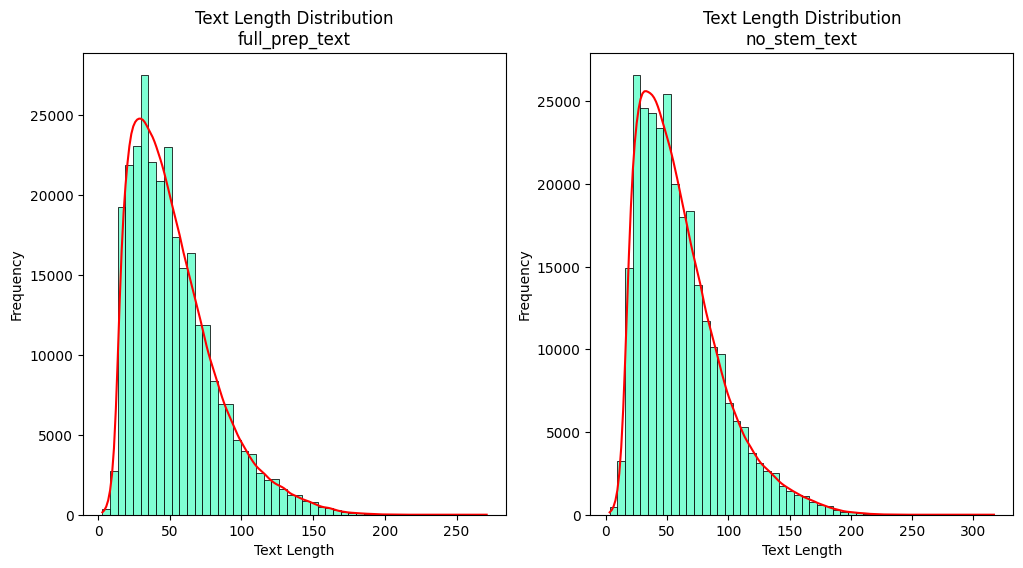

In [54]:
f, axes = plt.subplots(1, 2)
f.set_figheight(6)
f.set_figwidth(12)

columns = full_df.columns.to_numpy()[2:]
for i, (column, ax) in enumerate(zip(columns, axes)):
    text_length = full_df[column].apply(len)
    sns.histplot(text_length, bins=50, color='red', kde=True, facecolor='aquamarine', ax=ax)
    ax.set_title(f'Text Length Distribution\n{column}')
    ax.set_xlabel('Text Length')
    ax.set_ylabel('Frequency')

Как показано на графике, распределение длины текста практически не отличается. Это еще раз доказывает предобработанное начало датасета

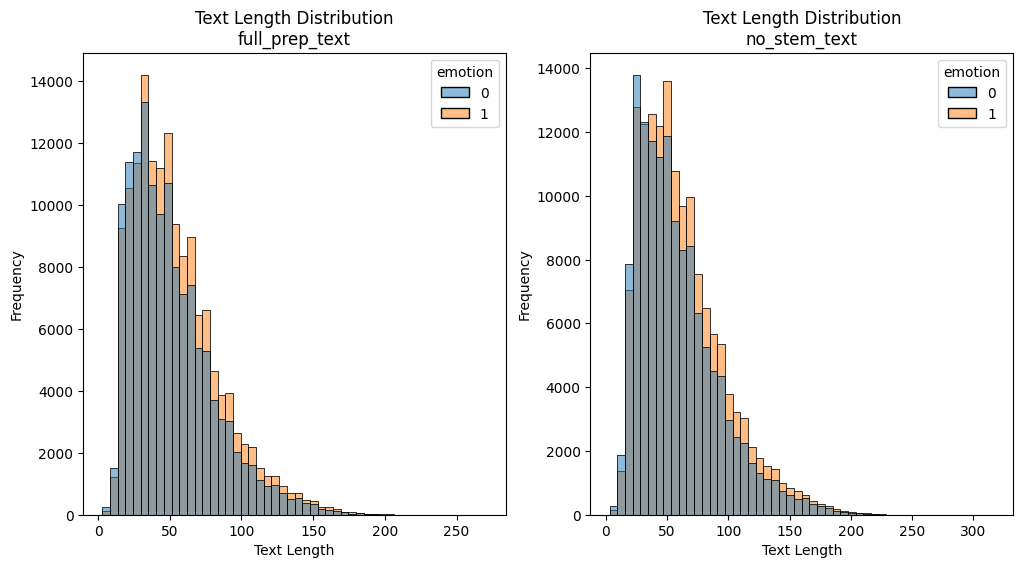

In [63]:
f, axes = plt.subplots(1, 2)
f.set_figheight(6)
f.set_figwidth(12)

df = full_df.copy()

columns = full_df.columns.to_numpy()[2:]
for i, (column, ax) in enumerate(zip(columns, axes)):
    df['length'] = df[column].apply(len)
    sns.histplot(data=df, ax=ax, x='length', hue='emotion', multiple='layer', bins=50)
    ax.set_title(f'Text Length Distribution\n{column}')
    ax.set_xlabel('Text Length')
    ax.set_ylabel('Frequency')

Данные графики показывают, что в датасете у эмоций одинаковое распределение длин текста, что свидетельствует об отсутствии значимой зависимости между длиной текста и эмоцией

## WordCloud

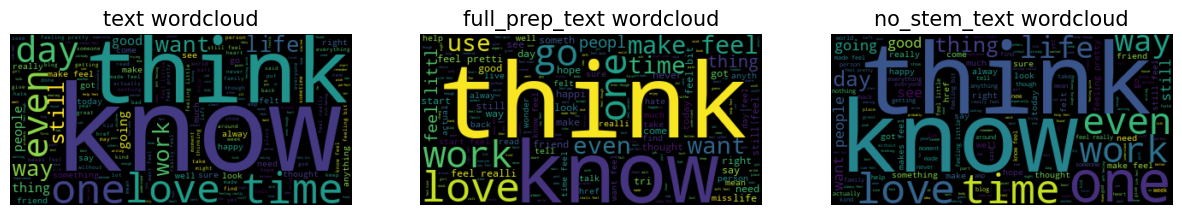

In [65]:
f, axes = plt.subplots(1, 3)
f.set_figheight(10)
f.set_figwidth(15)

columns = full_df.columns.to_numpy()[[0, 2, 3]]
for i, (column, ax) in enumerate(zip(columns, axes)):
    result = set(full_df[column])
    result_text = ' '.join(result)
    wordcloud = WordCloud().generate(result_text)

    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis('off')
    ax.set_title(f'{column} wordcloud', fontsize=15)

## Диаграмма распределения классов

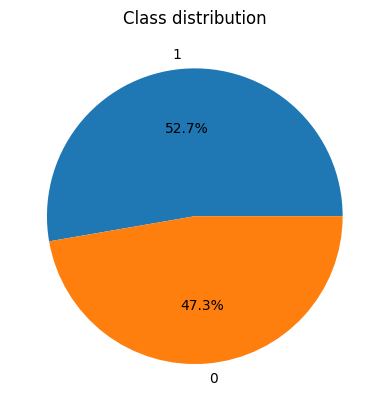

In [66]:
full_df.emotion.value_counts().plot(kind='pie', title='Class distribution', autopct='%1.1f%%')
plt.axis('off')
plt.show()

Распределение классов сбалансировано, следовательно, не нужно делать oversampling/undersampling

## Обучение всех доступных моделей sklearn 

In [3]:
import sys
sys.path.append('C:\projects\Python\ML_TOOLS')

In [4]:
from models_ml import Classifier

Авторский класс предоставляет возможность обучить сразу все доступные внутри модели на тренировочных данных. Во время обучения выводятся информация и предупреждения по каждой модели. Ссылка на проект на гитхабе: https://github.com/egrsid/ML_tools

первый варинт обработки

In [82]:
x_train, x_test, y_train, y_test = train_test_split(full_df.no_stem_text, full_df.emotion, test_size=0.15, random_state=42, stratify=full_df.emotion)

In [83]:
x_train.shape, x_test.shape

((240397,), (42424,))

In [86]:
vectorizer = TfidfVectorizer()
x_train_features = vectorizer.fit_transform(x_train)

In [87]:
x_test_features = vectorizer.transform(x_test)

In [9]:
with open('vectorizers/vect_no_stem_text.pickle', 'wb') as handle:
    pickle.dump(vectorizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [10]:
model = Classifier()
fitted_models = model.fit_all(x_train_features, y_train)

!Default models! 

===============BernoulliNB===============
WAS FITTED SUCCESSFULLY

===============CalibratedClassifierCV===============
WAS FITTED SUCCESSFULLY

===============CategoricalNB===============
FITTING FAILED: Sparse data was passed for X, but dense data is required. Use '.toarray()' to convert to a dense numpy array.

===============ClassifierChain===============
FITTING FAILED: ClassifierChain.__init__() missing 1 required positional argument: 'base_estimator'

===============ComplementNB===============
WAS FITTED SUCCESSFULLY

===============DecisionTreeClassifier===============
WAS FITTED SUCCESSFULLY

===============DummyClassifier===============
WAS FITTED SUCCESSFULLY

===============ExtraTreeClassifier===============
WAS FITTED SUCCESSFULLY

===============FixedThresholdClassifier===============
FITTING FAILED: FixedThresholdClassifier.__init__() missing 1 required positional argument: 'estimator'

===============GaussianNB===============
FITTING FAILED: Sparse da

In [11]:
with open('fitted_models/models_no_stem_text.pickle', 'wb') as handle:
    pickle.dump(fitted_models, handle, protocol=pickle.HIGHEST_PROTOCOL)

Добавление к обученным базовым моделям ансамблей

In [84]:
with open('vectorizers/vect_no_stem_text.pickle', 'rb') as handle:
    vectorizer_no_stem = pickle.load(handle)

c:\interpreter2\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator TfidfTransformer from version 1.5.1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\interpreter2\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator TfidfVectorizer from version 1.5.1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [85]:
x_train, x_test = vectorizer_no_stem.transform(x_train), vectorizer_no_stem.transform(x_test)

In [86]:
fitted_ensembles = {}

In [87]:
model_rfc = Classifier(RandomForestClassifier(n_jobs=-1))
model_rfc.fit(x_train, y_train)
fitted_ensembles[model_rfc.model.__class__.__name__] = model_rfc

In [88]:
model_ens = Classifier(GradientBoostingClassifier())

In [89]:
fitted_ens = model_ens.fit_all(x_train, y_train)

!Boosting models! 

===============CatBoostClassifier===============
Learning rate set to 0.107051
0:	learn: 0.6879292	total: 246ms	remaining: 4m 5s
1:	learn: 0.6829870	total: 467ms	remaining: 3m 52s
2:	learn: 0.6777167	total: 682ms	remaining: 3m 46s
3:	learn: 0.6711474	total: 896ms	remaining: 3m 43s
4:	learn: 0.6656477	total: 1.12s	remaining: 3m 43s
5:	learn: 0.6601286	total: 1.33s	remaining: 3m 40s
6:	learn: 0.6554851	total: 1.54s	remaining: 3m 38s
7:	learn: 0.6504130	total: 1.75s	remaining: 3m 37s
8:	learn: 0.6447037	total: 1.96s	remaining: 3m 35s
9:	learn: 0.6395545	total: 2.17s	remaining: 3m 34s
10:	learn: 0.6342572	total: 2.38s	remaining: 3m 33s
11:	learn: 0.6288081	total: 2.59s	remaining: 3m 33s
12:	learn: 0.6234900	total: 2.8s	remaining: 3m 32s
13:	learn: 0.6189379	total: 3.01s	remaining: 3m 32s
14:	learn: 0.6141906	total: 3.23s	remaining: 3m 31s
15:	learn: 0.6097310	total: 3.45s	remaining: 3m 32s
16:	learn: 0.6057164	total: 3.67s	remaining: 3m 32s
17:	learn: 0.6014327	total: 3

In [90]:
fitted_ensembles.update(fitted_ens)  # все модели в одном словаре

In [91]:
with open('fitted_models/ensembles_no_stem_text.pickle', 'wb') as handle:
    pickle.dump(fitted_ensembles, handle, protocol=pickle.HIGHEST_PROTOCOL)

второй вариант датасета

In [92]:
x_train, x_test, y_train, y_test = train_test_split(full_df.full_prep_text, full_df.emotion, test_size=0.15, random_state=42, stratify=full_df.emotion)

In [13]:
vectorizer = TfidfVectorizer()
x_train_features = vectorizer.fit_transform(x_train)
x_test_features = vectorizer.transform(x_test)

In [14]:
with open('vectorizers/vect_full_prep_text.pickle', 'wb') as handle:
    pickle.dump(vectorizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [15]:
model = Classifier()
fitted_models = model.fit_all(x_train_features, y_train)

!Default models! 

===============BernoulliNB===============
WAS FITTED SUCCESSFULLY

===============CalibratedClassifierCV===============
WAS FITTED SUCCESSFULLY

===============CategoricalNB===============
FITTING FAILED: Sparse data was passed for X, but dense data is required. Use '.toarray()' to convert to a dense numpy array.

===============ClassifierChain===============
FITTING FAILED: ClassifierChain.__init__() missing 1 required positional argument: 'base_estimator'

===============ComplementNB===============
WAS FITTED SUCCESSFULLY

===============DecisionTreeClassifier===============
WAS FITTED SUCCESSFULLY

===============DummyClassifier===============
WAS FITTED SUCCESSFULLY

===============ExtraTreeClassifier===============
WAS FITTED SUCCESSFULLY

===============FixedThresholdClassifier===============
FITTING FAILED: FixedThresholdClassifier.__init__() missing 1 required positional argument: 'estimator'

===============GaussianNB===============
FITTING FAILED: Sparse da

In [16]:
with open('fitted_models/models_full_prep_text.pickle', 'wb') as handle:
    pickle.dump(fitted_models, handle, protocol=pickle.HIGHEST_PROTOCOL)

Обучение ансамблей для второго варианта датасета

In [25]:
with open('vectorizers/vect_full_prep_text.pickle', 'rb') as handle:
    vectorizer_full_prep = pickle.load(handle)

In [94]:
x_train, x_test = vectorizer_full_prep.transform(x_train), vectorizer_full_prep.transform(x_test)

In [95]:
fitted_ensembles = {}

In [96]:
model_rfc = Classifier(RandomForestClassifier(n_jobs=-1))
model_rfc.fit(x_train, y_train)
fitted_ensembles[model_rfc.model.__class__.__name__] = model_rfc

In [97]:
model_ens = Classifier(GradientBoostingClassifier())

In [98]:
fitted_ens = model_ens.fit_all(x_train, y_train)

!Boosting models! 

===============CatBoostClassifier===============
Learning rate set to 0.107051
0:	learn: 0.6881616	total: 187ms	remaining: 3m 6s
1:	learn: 0.6831995	total: 366ms	remaining: 3m 2s
2:	learn: 0.6778701	total: 562ms	remaining: 3m 6s
3:	learn: 0.6727794	total: 739ms	remaining: 3m 3s
4:	learn: 0.6668656	total: 910ms	remaining: 3m 1s
5:	learn: 0.6616221	total: 1.08s	remaining: 2m 58s
6:	learn: 0.6571495	total: 1.25s	remaining: 2m 58s
7:	learn: 0.6523906	total: 1.43s	remaining: 2m 57s
8:	learn: 0.6477643	total: 1.61s	remaining: 2m 57s
9:	learn: 0.6427524	total: 1.78s	remaining: 2m 55s
10:	learn: 0.6377454	total: 1.95s	remaining: 2m 55s
11:	learn: 0.6331471	total: 2.12s	remaining: 2m 54s
12:	learn: 0.6282383	total: 2.3s	remaining: 2m 54s
13:	learn: 0.6242851	total: 2.47s	remaining: 2m 53s
14:	learn: 0.6200245	total: 2.66s	remaining: 2m 54s
15:	learn: 0.6154066	total: 2.83s	remaining: 2m 54s
16:	learn: 0.6116941	total: 3.01s	remaining: 2m 54s
17:	learn: 0.6083023	total: 3.19s

In [99]:
fitted_ensembles.update(fitted_ens)

In [100]:
with open('fitted_models/ensembles_full_prep_text.pickle', 'wb') as handle:
    pickle.dump(fitted_ensembles, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Оценка обучения

In [2]:
full_df = pd.read_csv('full_dataset_emotions_text.csv')

In [77]:
import sys
sys.path.append('C:\projects\Python\ML_TOOLS')

In [78]:
from models_ml import Classifier

загрузка данных по первому обучению

In [8]:
with open('fitted_models/models_no_stem_text.pickle', 'rb') as handle:
    fitted_models_no_stem = pickle.load(handle)

In [9]:
with open('fitted_models/ensembles_no_stem_text.pickle', 'rb') as handle:
    fitted_ensembles_no_stem = pickle.load(handle)

In [10]:
with open('vectorizers/vect_no_stem_text.pickle', 'rb') as handle:
    vectorizer_no_stem = pickle.load(handle)

In [13]:
x_train1, x_test1, y_train1, y_test1 = train_test_split(full_df.no_stem_text, full_df.emotion, test_size=0.15, random_state=42, stratify=full_df.emotion)

In [14]:
x_test_no_stem = vectorizer_no_stem.transform(x_test1)

загрузка данных по второму обучению

In [11]:
with open('fitted_models/models_full_prep_text.pickle', 'rb') as handle:
    fitted_models_full_prep = pickle.load(handle)

In [12]:
with open('fitted_models/ensembles_full_prep_text.pickle', 'rb') as handle:
    fitted_ensembles_full_prep = pickle.load(handle)

In [13]:
with open('vectorizers/vect_full_prep_text.pickle', 'rb') as handle:
    vectorizer_full_prep = pickle.load(handle)

In [21]:
x_train2, x_test2, y_train2, y_test2 = train_test_split(full_df.full_prep_text, full_df.emotion, test_size=0.15, random_state=42, stratify=full_df.emotion)

In [22]:
x_test_full_prep = vectorizer_full_prep.transform(x_test2)

### Вывод метрик для каждой обученной модели

RadiusNeighborsClassifier выдает ошибку при попытке построения графика. Ошибка: No neighbors found for test samples array([   0,    2,    4, ..., 9991, 9994, 9996], dtype=int64), you can try using larger radius, giving a label for outliers, or considering removing them from your dataset

Сама ошибка возникает в результате неправильного подбора изначальных параметров. А исходя из того, что модель была обучена на начальных параметрах(нельзя было изменить основываясь на концепции метода fit_all), они не позволяют алгоритму работать корректно. Он просто не может найти соседей в заданном изначально в sklearn радиусе 1. 

Модель с такими погрешностями в работе ни в коем случае не может стать конечным выбором, даже если итоговая точность на определенных данных получилась бы наилучшей. Поэтому данная модель будет просто исключена из тестов

In [23]:
del fitted_models_no_stem['RadiusNeighborsClassifier']
del fitted_models_full_prep['RadiusNeighborsClassifier']

In [62]:
def show_roc_auc(models, x_test, y_test, x_size=4, y_size=4, figwidth=20, figheight=23, fontsize=20, ensembles=False, stemmed=False):
    f, axes = plt.subplots(x_size, y_size)
    f.set_figwidth(figwidth)
    f.set_figheight(figheight)
    f.suptitle(f"Evaluation of {'ensembles' if ensembles else 'models'} fitted on {'no_stem_text' if not stemmed else 'full_prep_text'}", fontsize=fontsize)
    f.tight_layout()
    for i, ax_row in enumerate(axes):
        for (model_name, model), ax in zip(list(models.items())[i*y_size:], ax_row):
            score = model.predict(x_test)
            RocCurveDisplay.from_predictions(
            y_test,
            score,
            color="darkorange",
            plot_chance_level=True,
            ax=ax
            )
            ax.set_title(model_name)

In [61]:
def show_confusion_matrix(models, x_test, y_test, x_size=4, y_size=4, figwidth=20, figheight=23, fontsize=20, ensembles=False, stemmed=False):
    f, axes = plt.subplots(x_size, y_size)
    f.set_figwidth(figwidth)
    f.set_figheight(figheight)
    f.suptitle(f"Evaluation of {'ensembles' if ensembles else 'models'} fitted on {'no_stem_text' if not stemmed else 'full_prep_text'}", fontsize=fontsize)
    f.tight_layout()
    
    for i, ax_row in enumerate(axes):
        for (model_name, model), ax in zip(list(models.items())[i*y_size:], ax_row):
            ax.set_title(model_name)
            ConfusionMatrixDisplay.from_estimator(model, x_test, y_test, ax=ax, colorbar=False, cmap='cividis')

In [26]:
def show_report(models, x_test, y_test):
    df = pd.DataFrame()
    for model_name, model in models.items():
        with io.capture_output():  # нужно, чтобы метод report не выводил сообщения о том, какие метрики не удалось посчитать
            pred = model.predict(x_test)
            df[model_name] = model.report(y_test, pred)
    return df

#### Для текста без стемминга

Построение roc_auc кривой

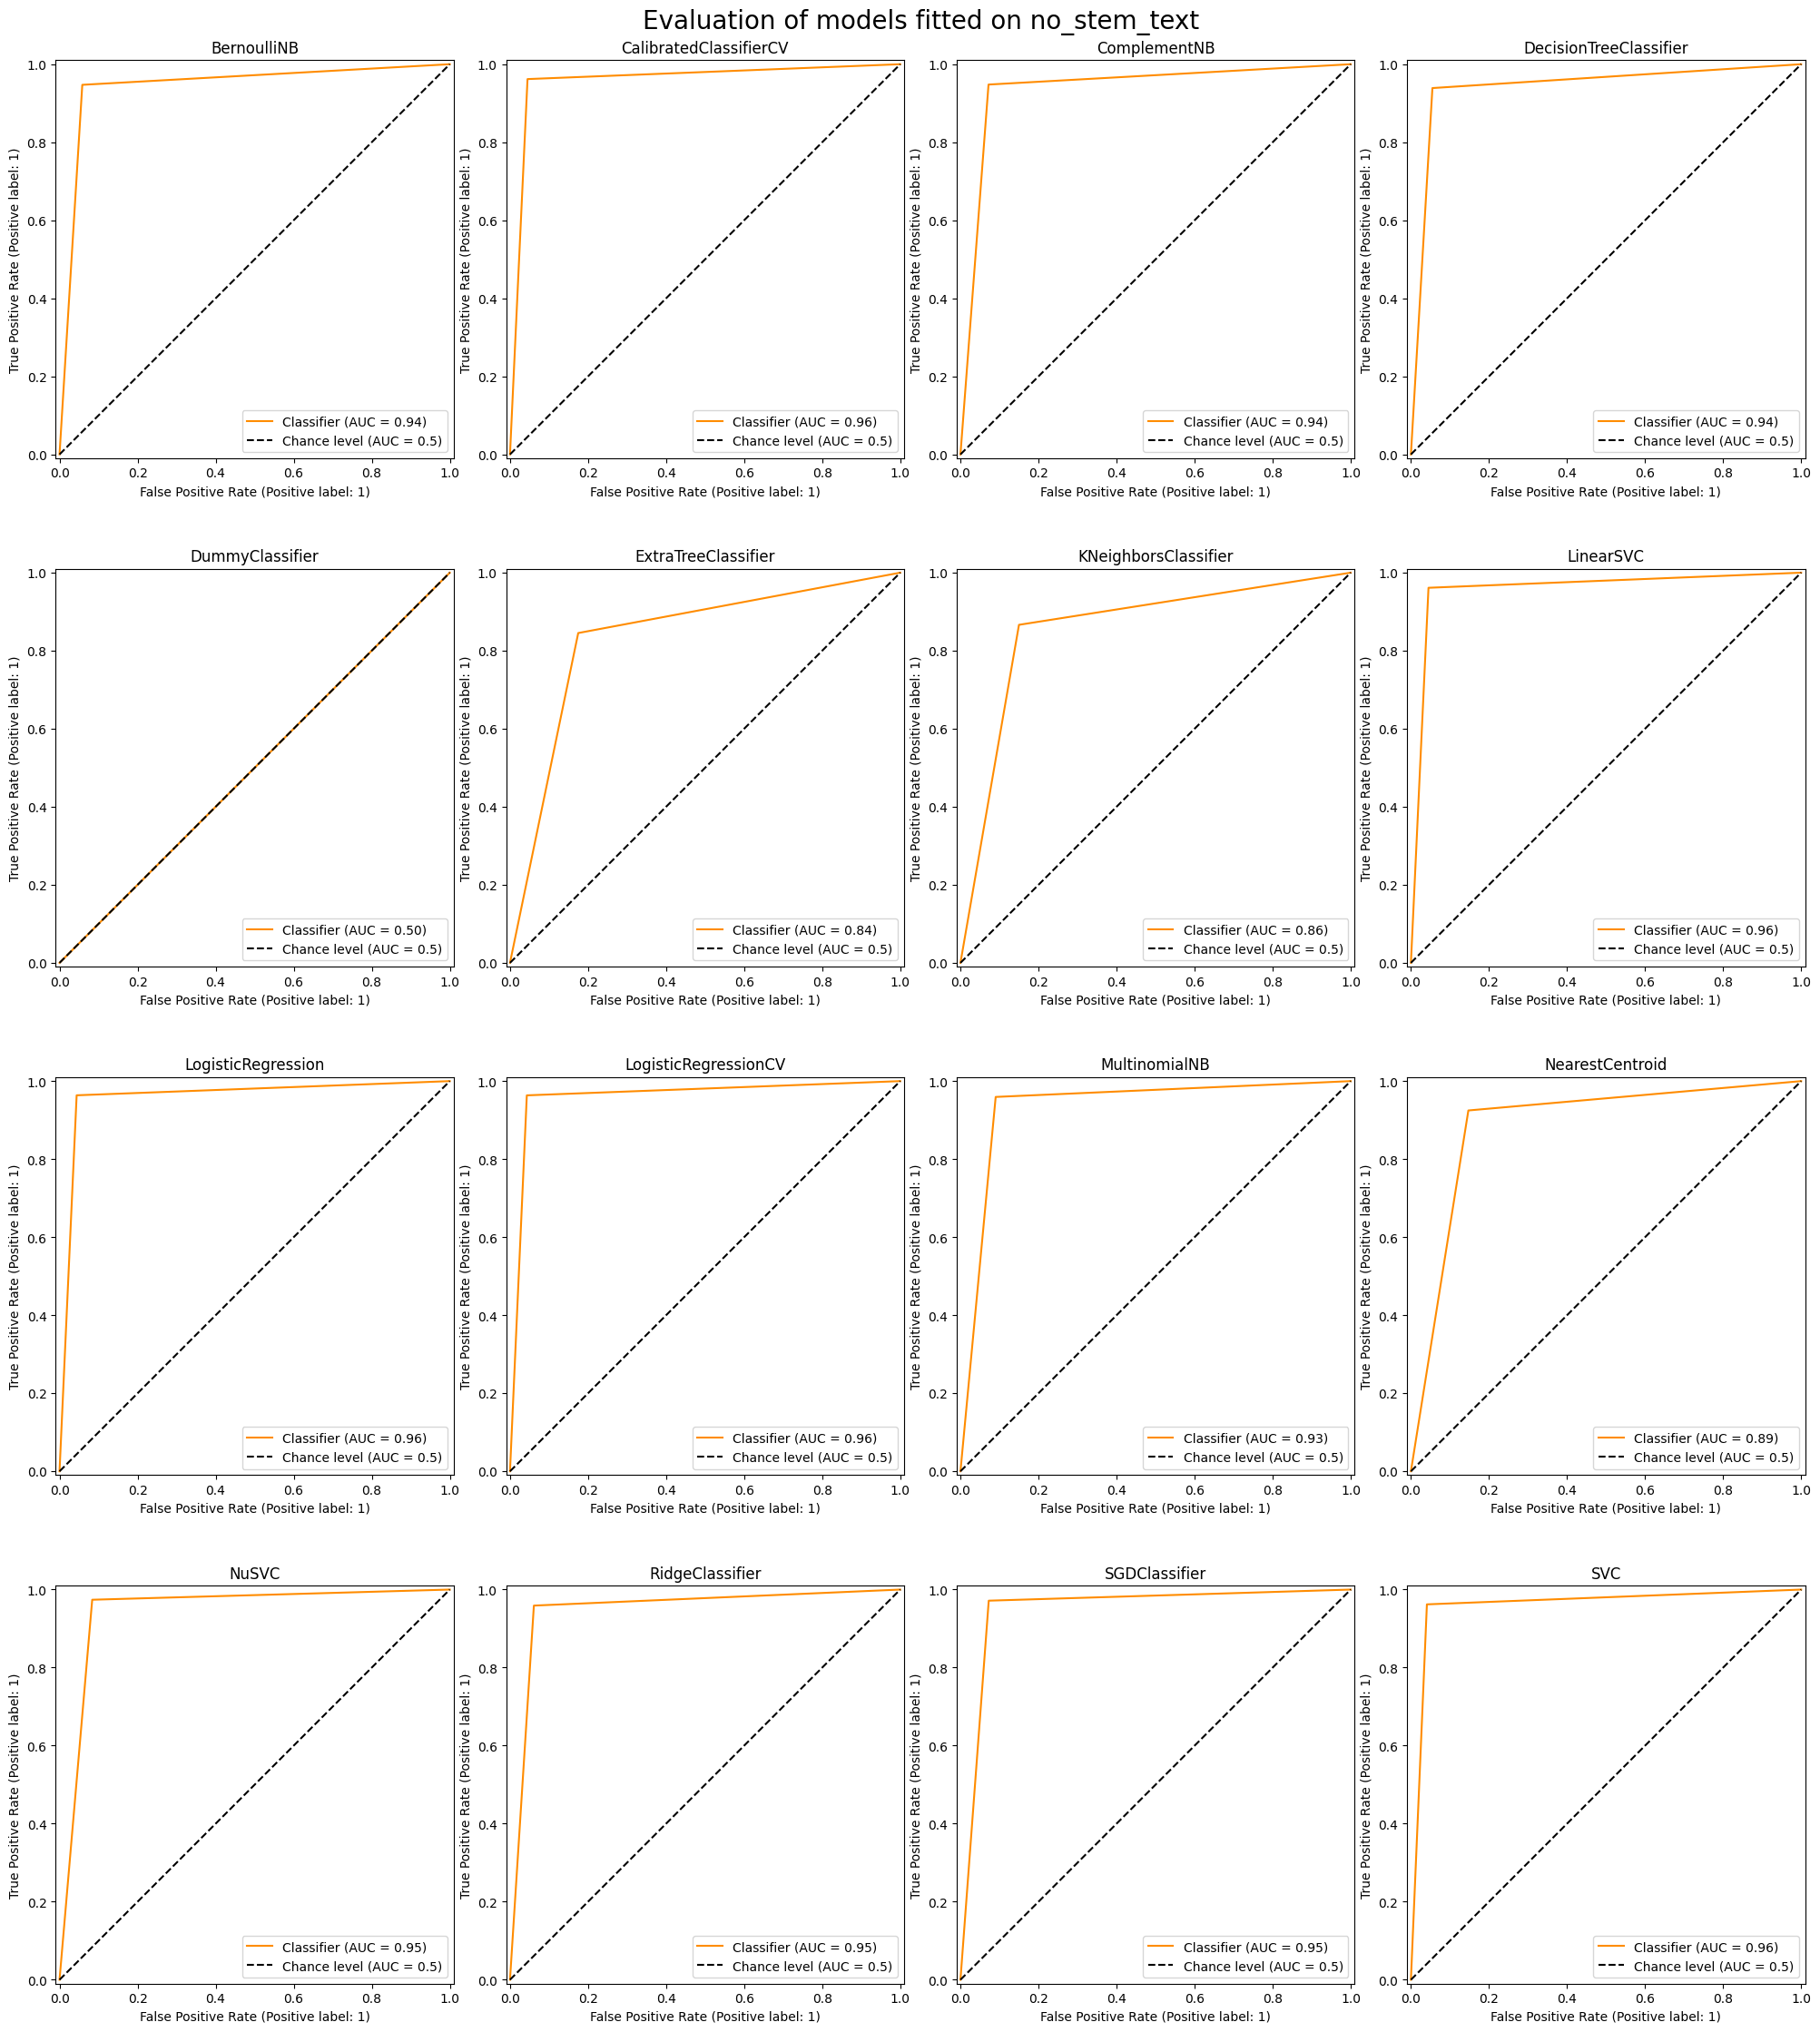

In [27]:
show_roc_auc(fitted_models_no_stem, x_test_no_stem, y_test1)

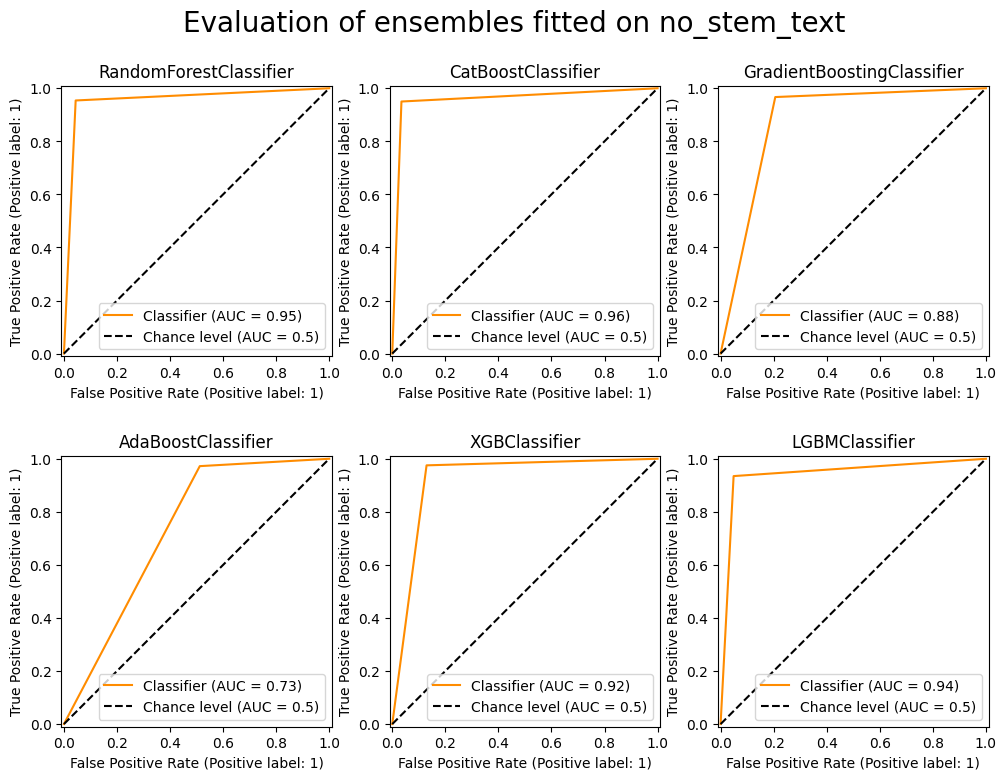

In [28]:
show_roc_auc(fitted_ensembles_no_stem, x_test_no_stem, y_test1, x_size=2, y_size=3, figheight=8, figwidth=10, ensembles=True)

Вывод матрицы путаницы

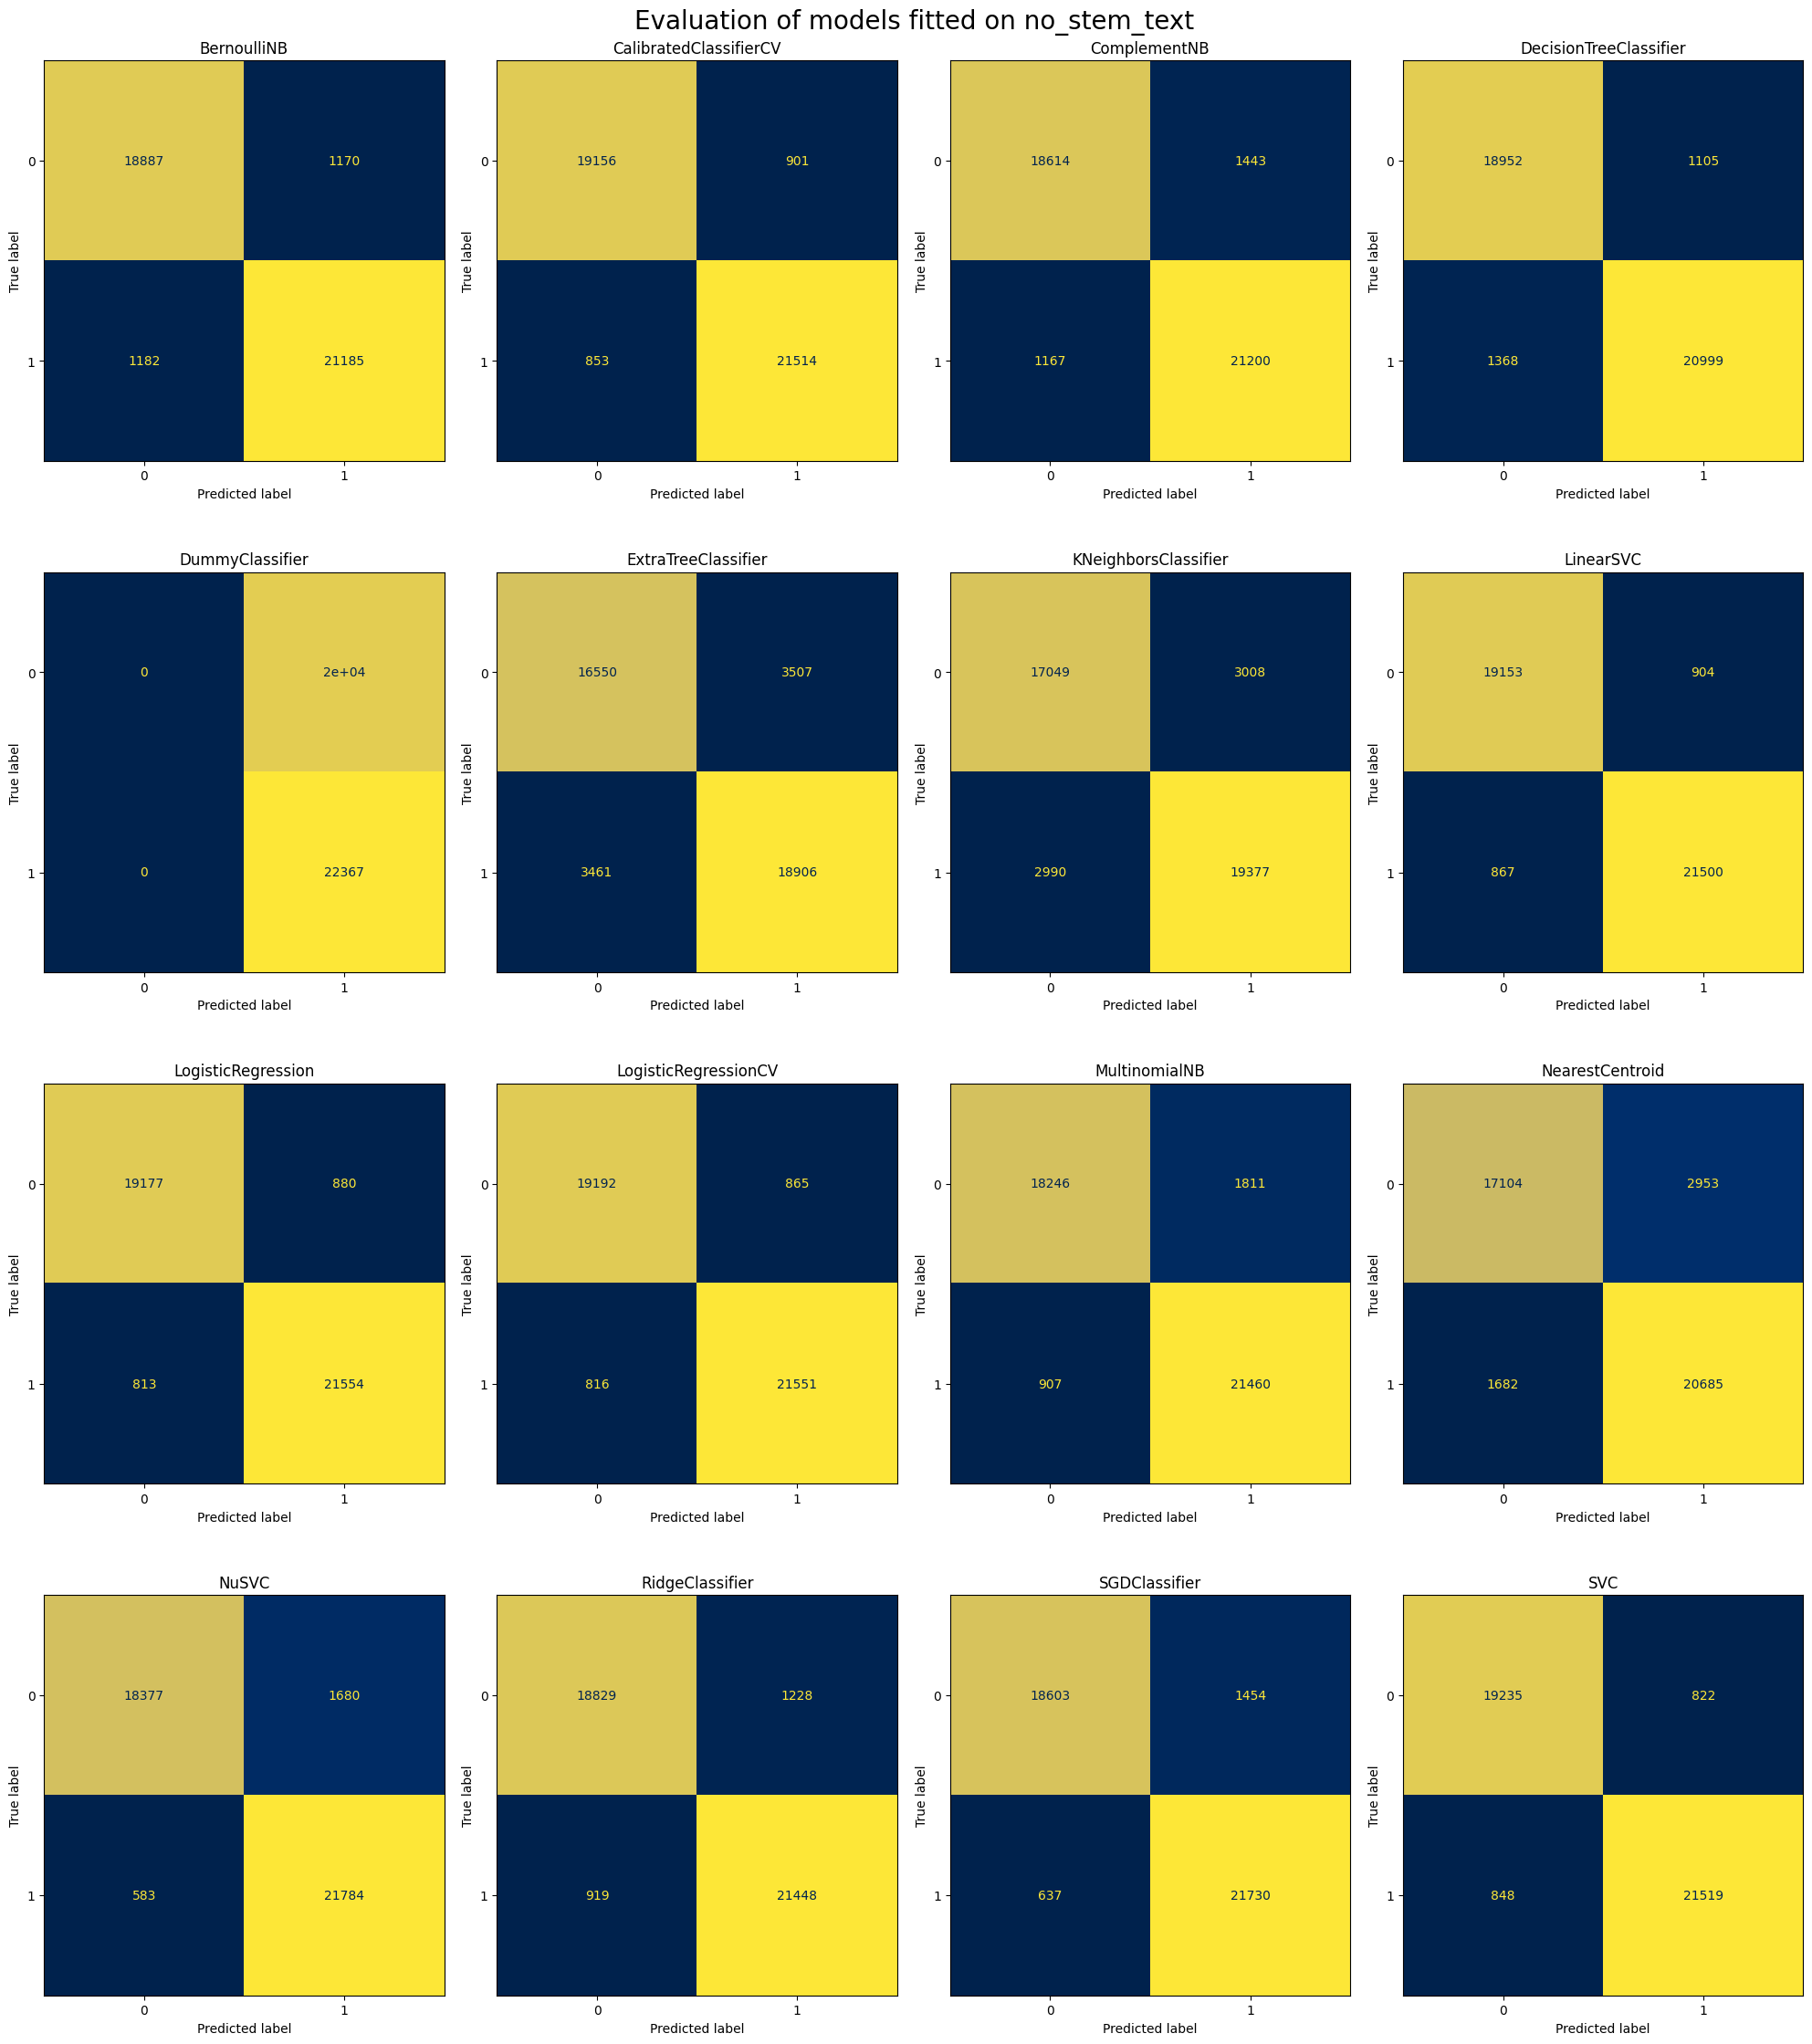

In [29]:
show_confusion_matrix(fitted_models_no_stem, x_test_no_stem, y_test1)

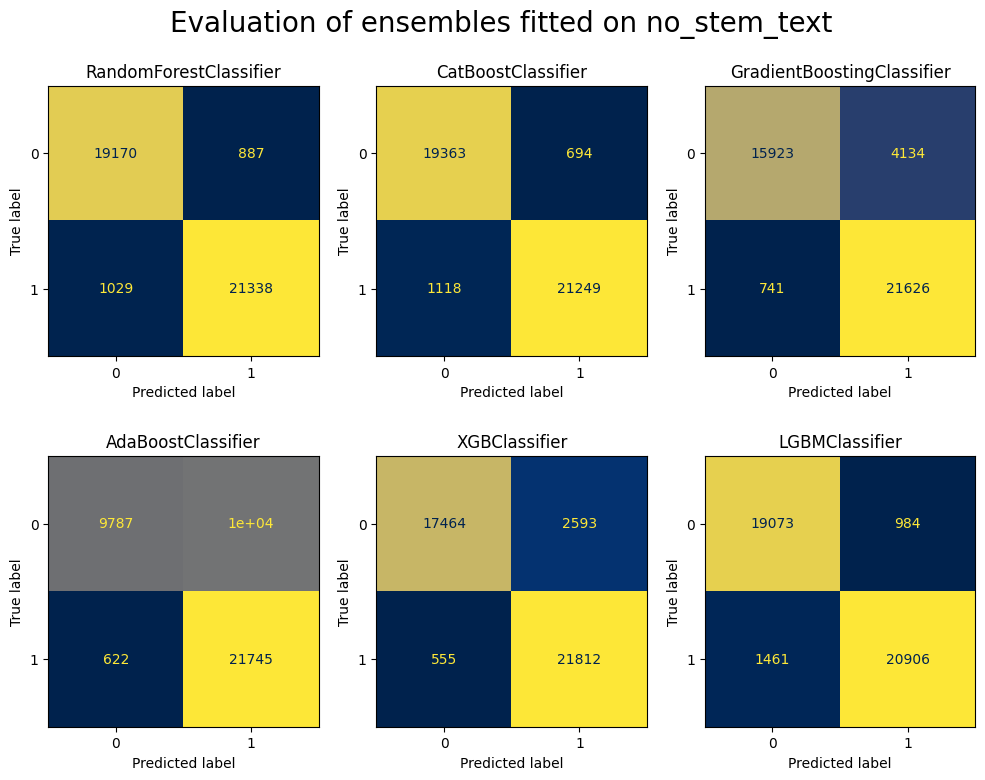

In [30]:
show_confusion_matrix(fitted_ensembles_no_stem, x_test_no_stem, y_test1, x_size=2, y_size=3, figheight=8, figwidth=10, ensembles=True)

Вывод report

In [31]:
fitted_models_no_stem.update(fitted_ensembles_no_stem)

In [32]:
rep_no_stem = show_report(fitted_models_no_stem, x_test_no_stem, y_test1)

In [33]:
rep_no_stem

,BernoulliNB,CalibratedClassifierCV,ComplementNB,DecisionTreeClassifier,DummyClassifier,ExtraTreeClassifier,KNeighborsClassifier,LinearSVC,LogisticRegression,LogisticRegressionCV,...,NuSVC,RidgeClassifier,SGDClassifier,SVC,RandomForestClassifier,CatBoostClassifier,GradientBoostingClassifier,AdaBoostClassifier,XGBClassifier,LGBMClassifier
accuracy_score,0.944560,0.958655,0.938478,0.941708,0.527225,0.835753,0.858618,0.958255,0.960093,0.960376,...,0.946658,0.949392,0.950712,0.960635,0.954837,0.957288,0.885089,0.743259,0.925797,0.942368
precision_score,0.947663,0.959804,0.936272,0.950009,0.527225,0.843528,0.865624,0.959650,0.960774,0.961411,...,0.928401,0.945846,0.937284,0.963207,0.960090,0.968373,0.839519,0.679213,0.893751,0.955048
recall_score,0.947154,0.961863,0.947825,0.938838,1.000000,0.845263,0.866321,0.961238,0.963652,0.963518,...,0.973935,0.958913,0.971521,0.962087,0.953995,0.950016,0.966871,0.972191,0.975187,0.934681
f1_score,0.947408,0.960832,0.942013,0.944391,0.690435,0.844395,0.865972,0.960443,0.962211,0.962463,...,0.950623,0.952334,0.954095,0.962647,0.957033,0.959106,0.898706,0.799713,0.932695,0.944755
d2_absolute_error_score,0.882734,0.912549,0.869871,0.876701,0.000000,0.652590,0.700952,0.911702,0.915591,0.916189,...,0.887172,0.892955,0.895747,0.916737,0.904472,0.909657,0.756943,0.456948,0.843047,0.878097
completeness_score,0.690382,0.751208,0.666664,0.679082,1.000000,0.354663,0.411246,0.749370,0.757821,0.759083,...,0.709419,0.711550,0.722464,0.760184,0.734092,0.746245,0.526529,0.291885,0.643134,0.682674
homogeneity_score,0.690413,0.751071,0.665898,0.679670,0.000000,0.354602,0.411218,0.749265,0.757627,0.758942,...,0.705149,0.710624,0.719492,0.760256,0.734456,0.747205,0.510024,0.235130,0.633938,0.683634
jaccard_score,0.900072,0.924618,0.890382,0.894640,0.527225,0.730695,0.763626,0.923897,0.927173,0.927643,...,0.905893,0.909006,0.912220,0.927983,0.917606,0.921426,0.816045,0.666268,0.873878,0.895294
brier_score_loss,0.055440,0.041345,0.061522,0.058292,0.472775,0.164247,0.141382,0.041745,0.039907,0.039624,...,0.053342,0.050608,0.049288,0.039365,0.045163,0.042712,0.114911,0.256741,0.074203,0.057632
d2_tweedie_score,0.777579,0.834130,0.753181,0.766137,-0.896723,0.341060,0.432789,0.832523,0.839899,0.841033,...,0.785996,0.796965,0.802261,0.842074,0.818810,0.828645,0.538988,-0.030020,0.702304,0.768785


In [36]:
rep_no_stem.to_csv('reports/report_no_stem_text.csv', index=False)

#### Для полностью обработанного текста

построение roc_auc кривой

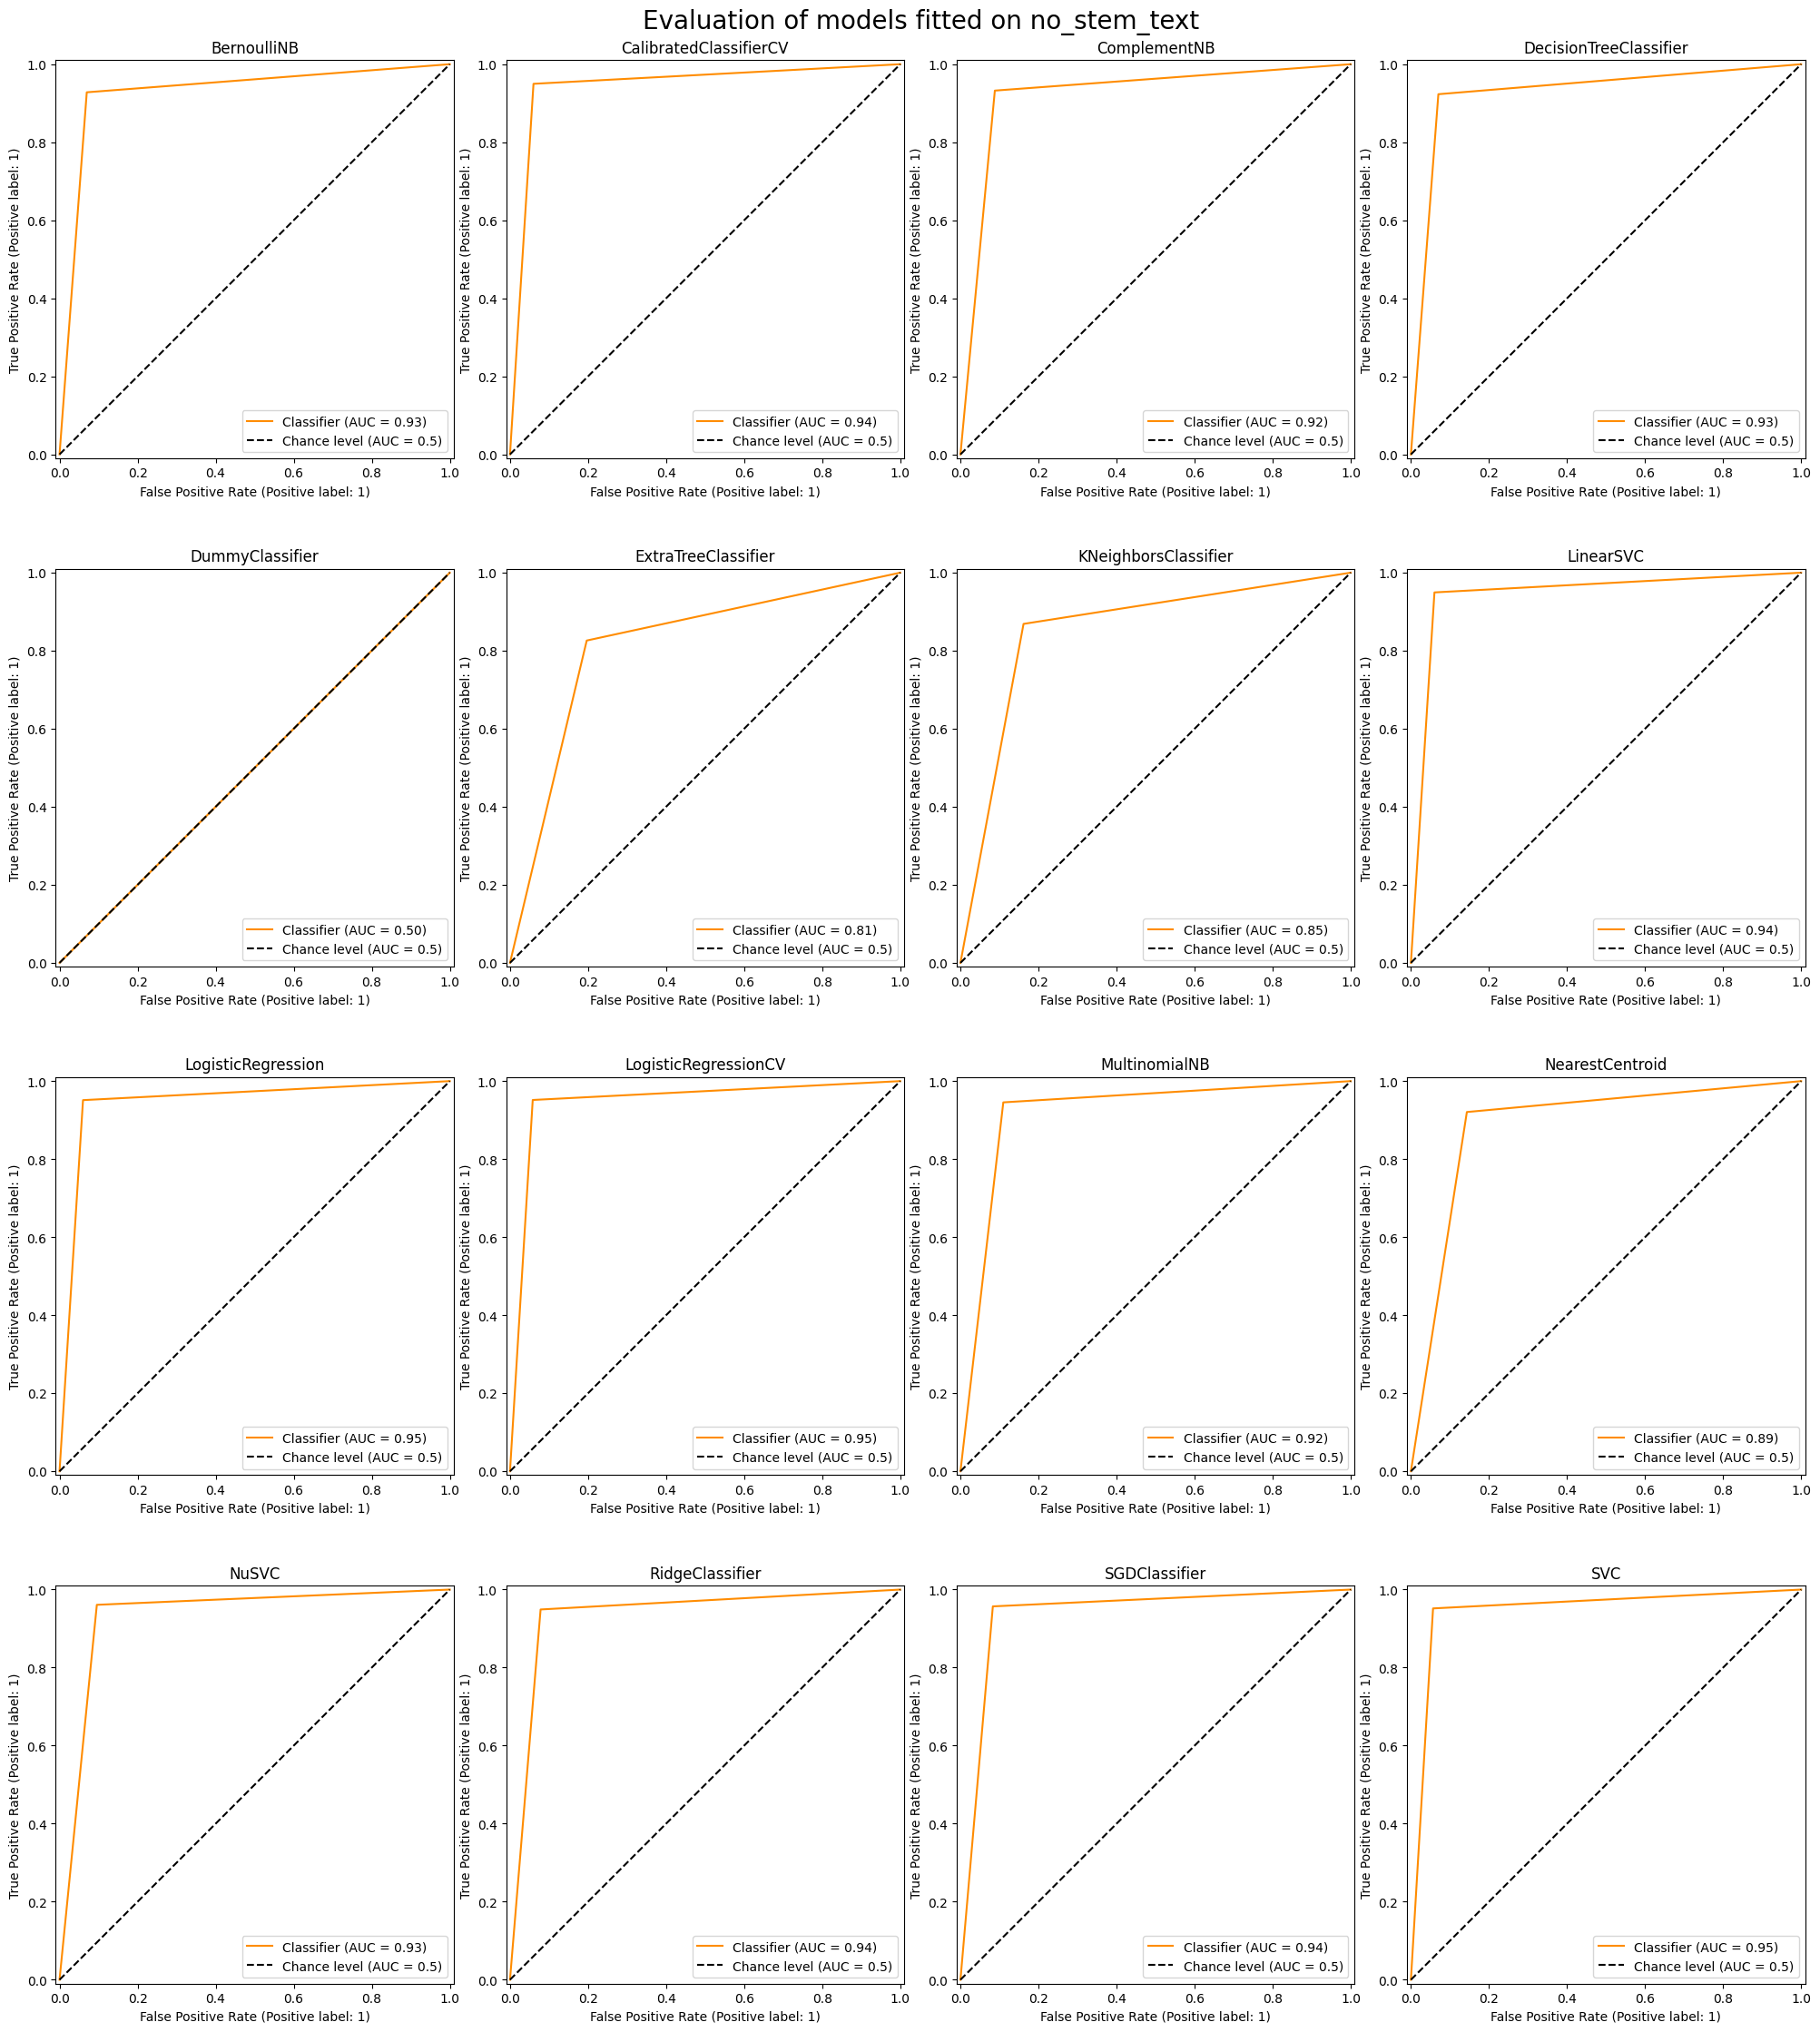

In [37]:
show_roc_auc(fitted_models_full_prep, x_test_full_prep, y_test2)

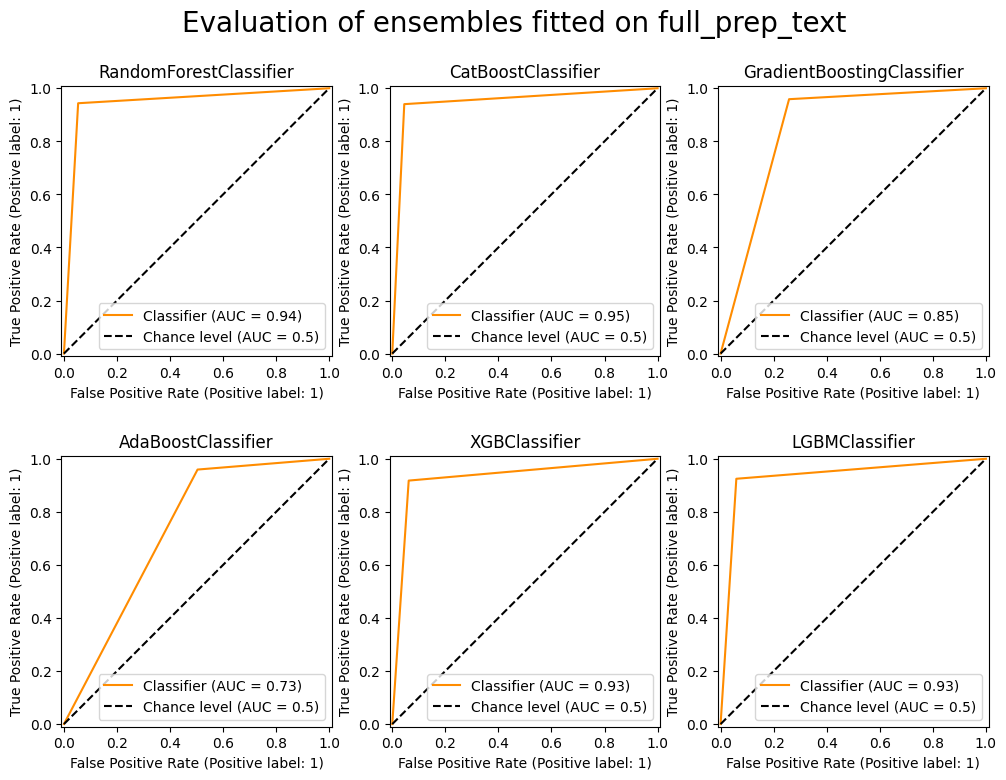

In [38]:
show_roc_auc(fitted_ensembles_full_prep, x_test_full_prep, y_test2, x_size=2, y_size=3, figheight=8, figwidth=10, ensembles=True, stemmed=True)

Вывод матрицы путаницы

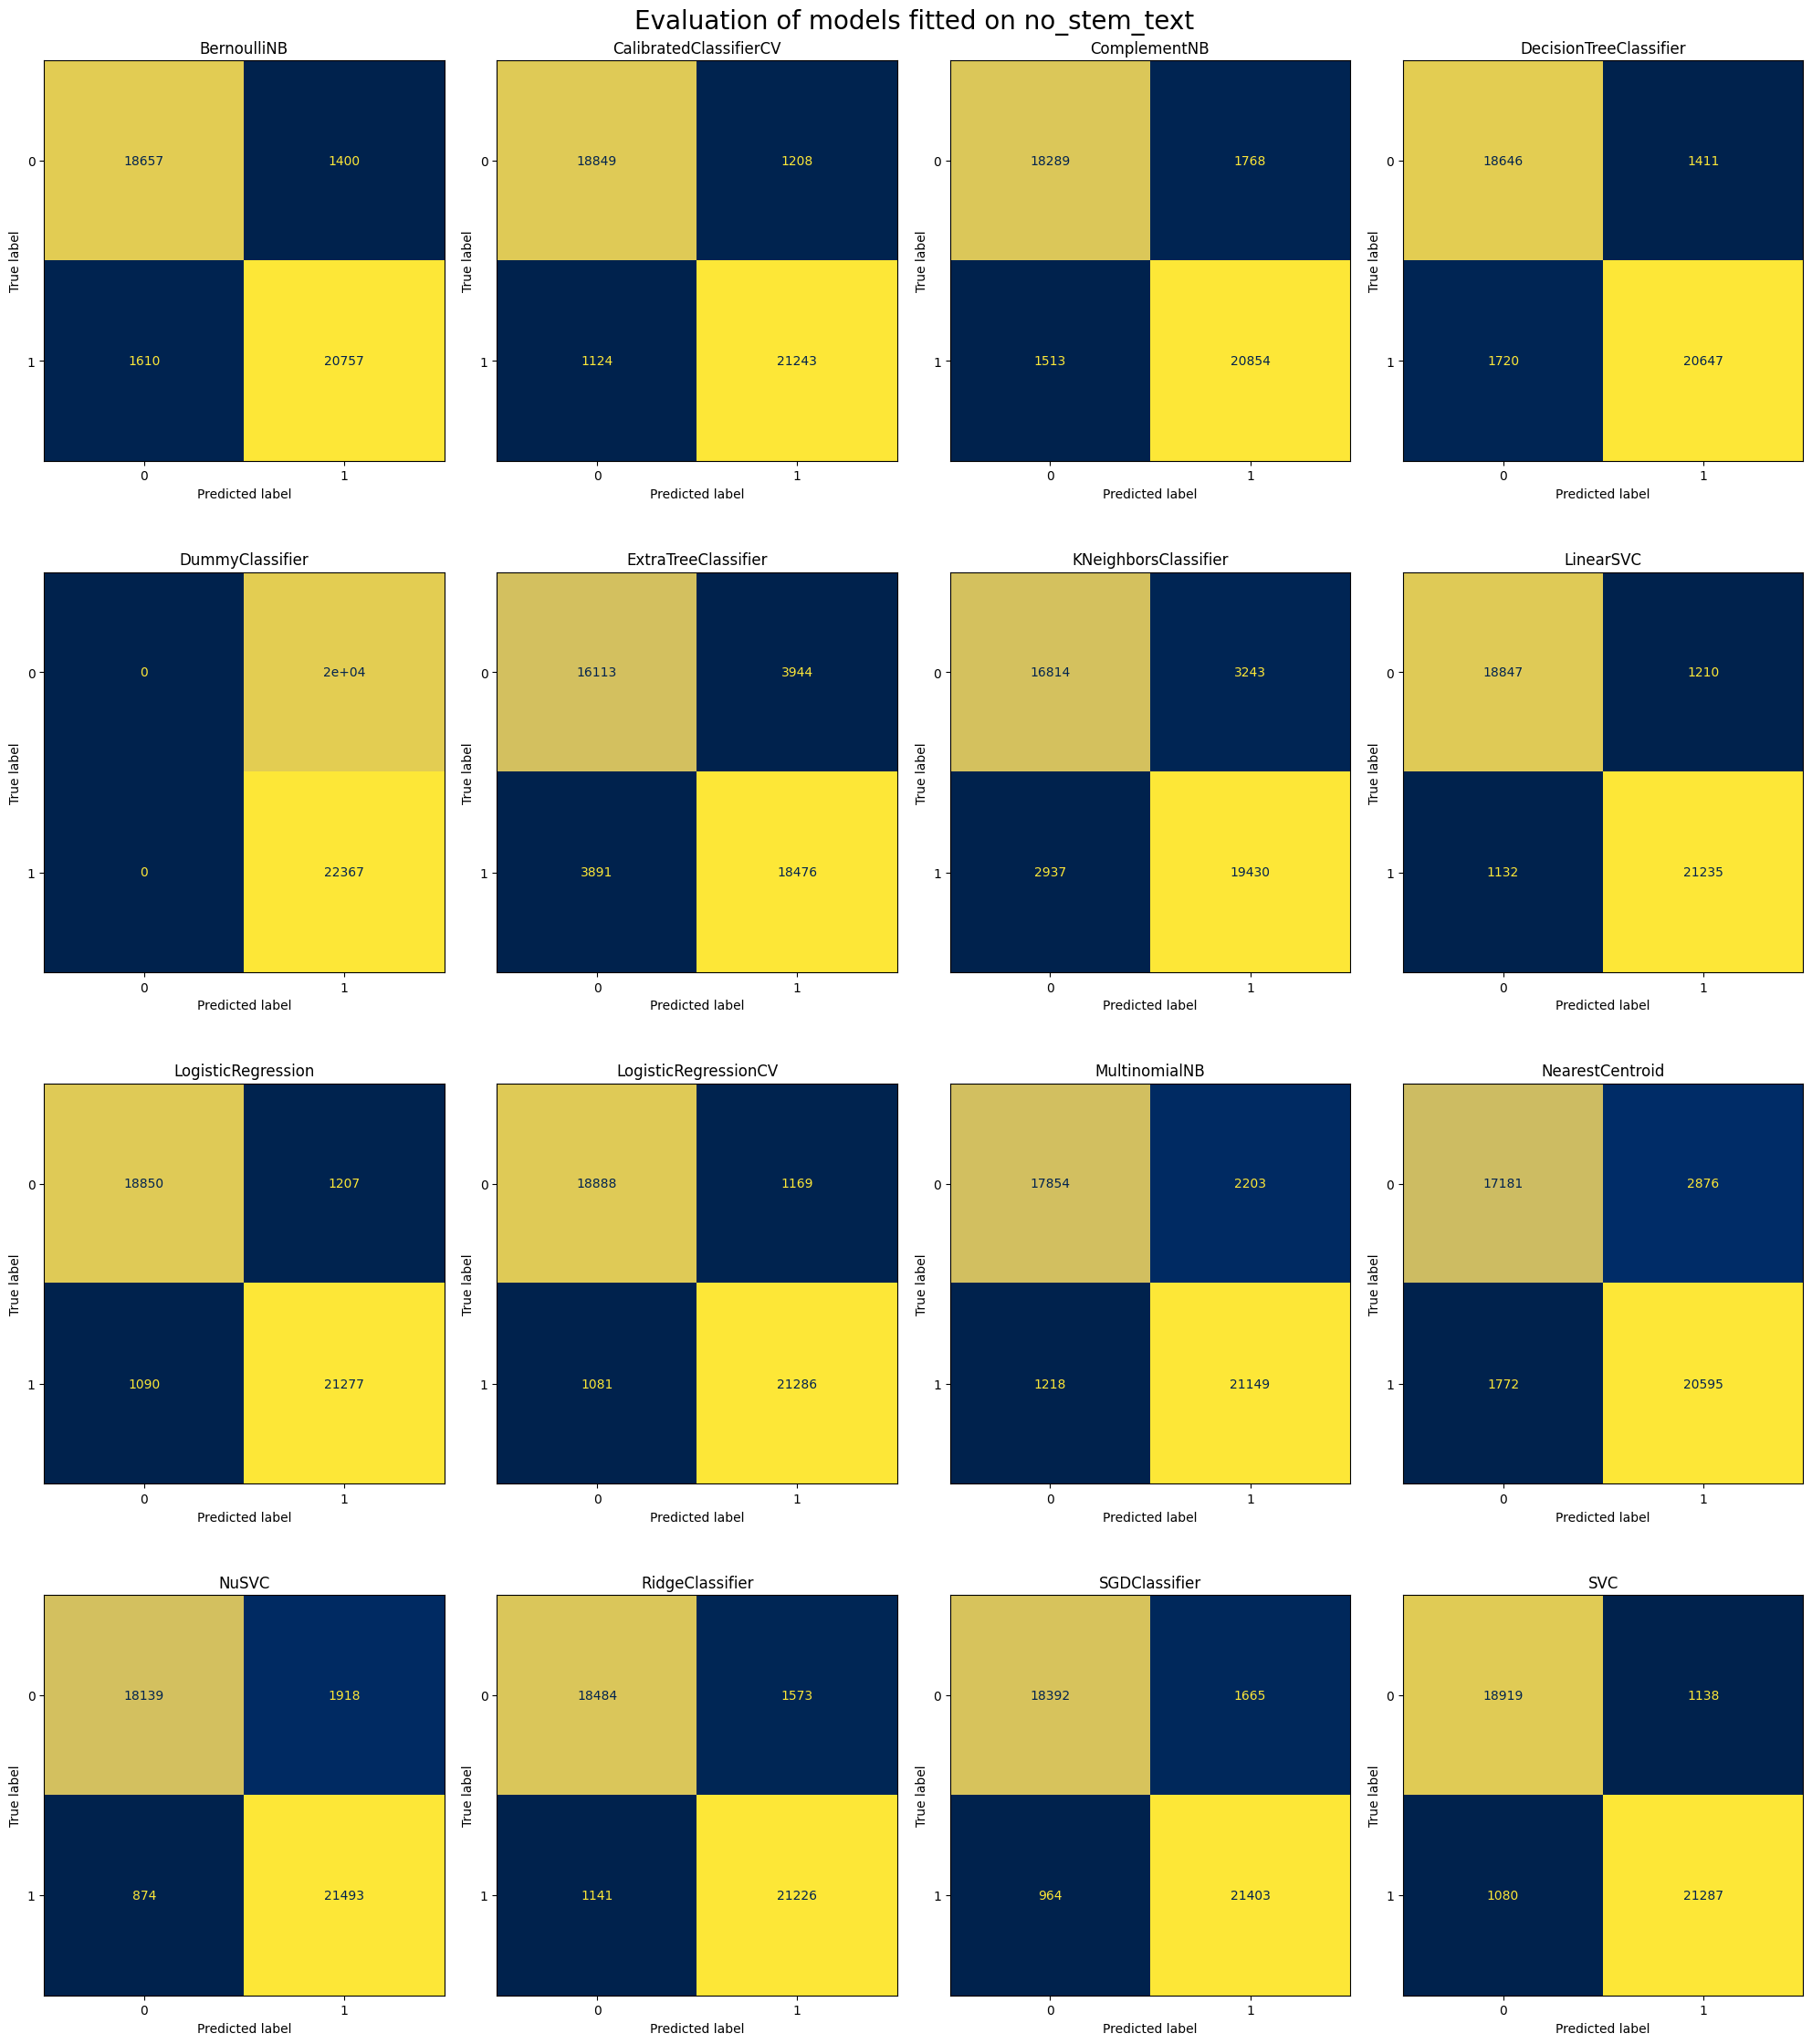

In [39]:
show_confusion_matrix(fitted_models_full_prep, x_test_full_prep, y_test1)

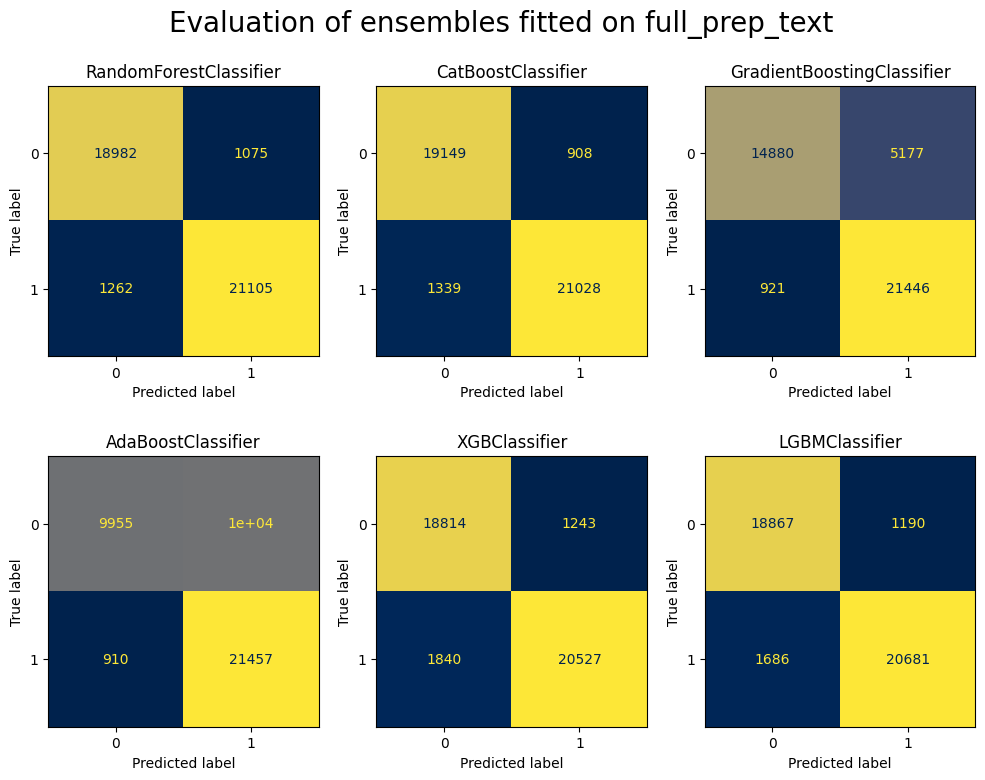

In [40]:
show_confusion_matrix(fitted_ensembles_full_prep, x_test_full_prep, y_test2, x_size=2, y_size=3, figheight=8, figwidth=10, ensembles=True, stemmed=True)

Вывод report

In [41]:
fitted_models_full_prep.update(fitted_ensembles_full_prep)

In [42]:
rep_full_prep = show_report(fitted_models_full_prep, x_test_full_prep, y_test2)

In [43]:
rep_full_prep

,BernoulliNB,CalibratedClassifierCV,ComplementNB,DecisionTreeClassifier,DummyClassifier,ExtraTreeClassifier,KNeighborsClassifier,LinearSVC,LogisticRegression,LogisticRegressionCV,...,NuSVC,RidgeClassifier,SGDClassifier,SVC,RandomForestClassifier,CatBoostClassifier,GradientBoostingClassifier,AdaBoostClassifier,XGBClassifier,LGBMClassifier
accuracy_score,0.929050,0.945031,0.922662,0.926197,0.527225,0.815317,0.854328,0.944795,0.945856,0.946964,...,0.934188,0.936027,0.938030,0.947718,0.944913,0.947035,0.856261,0.740430,0.927329,0.932208
precision_score,0.936815,0.946194,0.921846,0.936032,0.527225,0.824086,0.856966,0.946090,0.946317,0.947940,...,0.918073,0.931006,0.927822,0.949253,0.951533,0.958607,0.805544,0.679901,0.942903,0.945590
recall_score,0.928019,0.949747,0.932356,0.923101,1.000000,0.826038,0.868690,0.949390,0.951267,0.951670,...,0.960925,0.948987,0.956901,0.951715,0.943578,0.940135,0.958823,0.959315,0.917736,0.924621
f1_score,0.932396,0.947967,0.927071,0.929522,0.690435,0.825061,0.862789,0.947737,0.948786,0.949801,...,0.939010,0.939911,0.942137,0.950482,0.947539,0.949281,0.875526,0.795794,0.930149,0.934988
d2_absolute_error_score,0.849928,0.883731,0.836416,0.843895,0.000000,0.609363,0.691878,0.883233,0.885476,0.887820,...,0.860797,0.864686,0.868924,0.889415,0.883482,0.887969,0.695966,0.450965,0.846288,0.856609
completeness_score,0.630023,0.692446,0.607074,0.619720,1.000000,0.308780,0.400374,0.691465,0.695924,0.700455,...,0.656732,0.657854,0.667904,0.703548,0.691941,0.701656,0.453999,0.266397,0.625106,0.642860
homogeneity_score,0.630469,0.692222,0.606435,0.620336,0.000000,0.308718,0.399859,0.691258,0.695606,0.700218,...,0.653029,0.656601,0.665635,0.703392,0.692382,0.702570,0.433378,0.219130,0.626134,0.643790
jaccard_score,0.873354,0.901082,0.864056,0.868324,0.527225,0.702216,0.758688,0.900666,0.902562,0.904402,...,0.885032,0.886633,0.890604,0.905637,0.900307,0.903459,0.778609,0.660846,0.869420,0.877913
brier_score_loss,0.070950,0.054969,0.077338,0.073803,0.472775,0.184683,0.145672,0.055205,0.054144,0.053036,...,0.065812,0.063973,0.061970,0.052282,0.055087,0.052965,0.143739,0.259570,0.072671,0.067792
d2_tweedie_score,0.715354,0.779471,0.689727,0.703912,-0.896723,0.259070,0.415578,0.778525,0.782780,0.787225,...,0.735970,0.743346,0.751384,0.790251,0.778998,0.787509,0.423333,-0.041368,0.708451,0.728026


In [44]:
rep_full_prep.to_csv('reports/report_full_prep_text.csv', index=False)

загрузка репортов

In [14]:
report_full_prep = pd.read_csv('reports/report_full_prep_text.csv')
report_no_stem = pd.read_csv('reports/report_no_stem_text.csv')

Анализируя полученные графики, репорты и матрицы путаницы, становится понятно, что модели лучше обучаются на данных без стемминга. Следующая задача - определить лучшую модель из представленных. Выведем явных лидеров

Исходя из того, что модели без стемминга обучились лучше, чем со стеммингом, можно сделать вывод, что леммматизацию делать не нужно. Следовательно изначальная гипотеза подтвердилась

In [47]:
useful_cols = ['LogisticRegressionCV', 'SVC', 'CatBoostClassifier', 'RandomForestClassifier']
res_df = report_no_stem[useful_cols]
res_df

,LogisticRegressionCV,SVC,CatBoostClassifier,RandomForestClassifier
accuracy_score,0.960376,0.960635,0.957288,0.954837
precision_score,0.961411,0.963207,0.968373,0.960090
recall_score,0.963518,0.962087,0.950016,0.953995
f1_score,0.962463,0.962647,0.959106,0.957033
d2_absolute_error_score,0.916189,0.916737,0.909657,0.904472
completeness_score,0.759083,0.760184,0.746245,0.734092
homogeneity_score,0.758942,0.760256,0.747205,0.734456
jaccard_score,0.927643,0.927983,0.921426,0.917606
brier_score_loss,0.039624,0.039365,0.042712,0.045163
d2_tweedie_score,0.841033,0.842074,0.828645,0.818810


Метрики данных моделей практически не отличаются, однако SVC значительно дольше обучается и делает предсказания на данных большого объема. Текстовые данные таковыми и являются. Это происходит за счет сложности модели SVC. Ее сложность - O(n_samples**2 * n_features). 

Учитывая очень маленьку разницу в метриках между моделями, следует убрать из рассмотрения модель SVC ввиду слишком высокой требовательности.

In [48]:
useful_cols = ['LogisticRegressionCV', 'CatBoostClassifier', 'RandomForestClassifier']
res_df = report_no_stem[useful_cols]
res_df

,LogisticRegressionCV,CatBoostClassifier,RandomForestClassifier
accuracy_score,0.960376,0.957288,0.954837
precision_score,0.961411,0.968373,0.960090
recall_score,0.963518,0.950016,0.953995
f1_score,0.962463,0.959106,0.957033
d2_absolute_error_score,0.916189,0.909657,0.904472
completeness_score,0.759083,0.746245,0.734092
homogeneity_score,0.758942,0.747205,0.734456
jaccard_score,0.927643,0.921426,0.917606
brier_score_loss,0.039624,0.042712,0.045163
d2_tweedie_score,0.841033,0.828645,0.818810


### Подбор гиперпараметров для выбранных моделей

In [22]:
x_train, x_test, y_train, y_test = train_test_split(full_df.text, full_df.emotion, test_size=5000, random_state=42, stratify=full_df.emotion)

In [41]:
# Функция для оптимизации гиперпараметров
def objective(trial, model_name):
    if model_name == 'CatBoostClassifier':
        model = CatBoostClassifier(
            iterations=trial.suggest_int('iterations', 1000, 2500),
            depth=trial.suggest_int('depth', 3, 10),
            learning_rate=trial.suggest_loguniform('learning_rate', 3e-2, 1e-1),
            l2_leaf_reg=trial.suggest_loguniform('l2_leaf_reg', 1e-4, 1e1),
            early_stopping_rounds=20,  # борьба против переобучения
            silent=True  # чтобы не выводился лосс по итерациям
        )
    
    elif model_name == 'LogisticRegressionCV':
        model = LogisticRegressionCV(
            Cs = trial.suggest_int('Cs', 1, 10),
            cv=trial.suggest_int('cv', 3, 10),
            max_iter = trial.suggest_int('max_iter', 1000, 2000),
            scoring='recall',
            penalty='l2',
            n_jobs=-1
        )
    
    elif model_name == 'RandomForestClassifier':
        model = RandomForestClassifier(
            n_estimators=trial.suggest_int('n_estimators', 100, 500),
            max_depth=trial.suggest_int('max_depth', 3, 10),
            min_samples_split=trial.suggest_int('min_samples_split', 2, 6),
            min_samples_leaf=trial.suggest_int('min_samples_leaf', 3, 12),
            n_jobs=-1
        )

    pipeline = Pipeline([
        ('tfidf', vectorizer_no_stem),
        ('model', model)
    ])

    pipeline.fit(x_train, y_train)
    y_pred = pipeline.predict(x_test)
    return recall_score(y_test, y_pred)

In [42]:
optuna.logging.set_verbosity(optuna.logging.INFO)

params_info = {}

with warnings.catch_warnings(record=False):
    for model_name in useful_cols:
        print(f"Оптимизация модели: {model_name}")
        # Создание исследования с направлением на максимизацию
        study = optuna.create_study(direction="maximize", study_name=f"{model_name} optimal parameter search")
        study.optimize(lambda trial: objective(trial, model_name), n_trials=50)

        params_info[model_name] = study.best_params

        # Вывод лучших параметров и метрики
        print(f"Наилучшие результаты для модели: {model_name}")
        print(f"Recall: {study.best_value:.4f}")
        print("Гиперпараметры:", study.best_params)
        print("-" * 50, '\n')

[I 2024-10-13 00:17:18,583] A new study created in memory with name: LogisticRegressionCV optimal parameter search


Оптимизация модели: LogisticRegressionCV


[I 2024-10-13 00:17:23,280] Trial 0 finished with value: 1.0 and parameters: {'Cs': 7, 'cv': 5, 'max_iter': 1602}. Best is trial 0 with value: 1.0.
[I 2024-10-13 00:17:27,905] Trial 1 finished with value: 1.0 and parameters: {'Cs': 4, 'cv': 6, 'max_iter': 1757}. Best is trial 0 with value: 1.0.
[I 2024-10-13 00:17:34,252] Trial 2 finished with value: 1.0 and parameters: {'Cs': 4, 'cv': 10, 'max_iter': 1643}. Best is trial 0 with value: 1.0.
[I 2024-10-13 00:17:36,788] Trial 3 finished with value: 1.0 and parameters: {'Cs': 1, 'cv': 7, 'max_iter': 1021}. Best is trial 0 with value: 1.0.
[I 2024-10-13 00:17:40,365] Trial 4 finished with value: 1.0 and parameters: {'Cs': 7, 'cv': 5, 'max_iter': 1641}. Best is trial 0 with value: 1.0.
[I 2024-10-13 00:17:44,251] Trial 5 finished with value: 1.0 and parameters: {'Cs': 7, 'cv': 9, 'max_iter': 1183}. Best is trial 0 with value: 1.0.
[I 2024-10-13 00:17:48,649] Trial 6 finished with value: 1.0 and parameters: {'Cs': 7, 'cv': 10, 'max_iter': 13

Наилучшие результаты для модели: LogisticRegressionCV
Recall: 1.0000
Гиперпараметры: {'Cs': 7, 'cv': 5, 'max_iter': 1602}
-------------------------------------------------- 

Оптимизация модели: CatBoostClassifier


[I 2024-10-13 00:24:29,153] Trial 0 finished with value: 0.9480273141122914 and parameters: {'iterations': 2423, 'depth': 3, 'learning_rate': 0.0762789915865626, 'l2_leaf_reg': 0.5124101209541098}. Best is trial 0 with value: 0.9480273141122914.
[I 2024-10-13 00:26:22,399] Trial 1 finished with value: 0.9423368740515933 and parameters: {'iterations': 1082, 'depth': 3, 'learning_rate': 0.08389810688820344, 'l2_leaf_reg': 0.943742068390874}. Best is trial 0 with value: 0.9480273141122914.
[I 2024-10-13 00:30:39,069] Trial 2 finished with value: 0.9419575113808801 and parameters: {'iterations': 2450, 'depth': 3, 'learning_rate': 0.036400888728736834, 'l2_leaf_reg': 0.005384735190539803}. Best is trial 0 with value: 0.9480273141122914.
[I 2024-10-13 00:41:24,663] Trial 3 finished with value: 0.9514415781487102 and parameters: {'iterations': 1869, 'depth': 7, 'learning_rate': 0.06554322072435179, 'l2_leaf_reg': 2.1759134549748054}. Best is trial 3 with value: 0.9514415781487102.
Training ha

Наилучшие результаты для модели: CatBoostClassifier
Recall: 0.9753
Гиперпараметры: {'iterations': 1536, 'depth': 10, 'learning_rate': 0.03432726054471221, 'l2_leaf_reg': 0.00045719653779151335}
-------------------------------------------------- 

Оптимизация модели: RandomForestClassifier


[I 2024-10-13 10:08:45,333] Trial 0 finished with value: 1.0 and parameters: {'n_estimators': 137, 'max_depth': 8, 'min_samples_split': 6, 'min_samples_leaf': 9}. Best is trial 0 with value: 1.0.
[I 2024-10-13 10:08:50,152] Trial 1 finished with value: 1.0 and parameters: {'n_estimators': 407, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 12}. Best is trial 0 with value: 1.0.
[I 2024-10-13 10:08:53,584] Trial 2 finished with value: 1.0 and parameters: {'n_estimators': 238, 'max_depth': 7, 'min_samples_split': 3, 'min_samples_leaf': 11}. Best is trial 0 with value: 1.0.
[I 2024-10-13 10:08:58,060] Trial 3 finished with value: 1.0 and parameters: {'n_estimators': 333, 'max_depth': 9, 'min_samples_split': 2, 'min_samples_leaf': 12}. Best is trial 0 with value: 1.0.
[I 2024-10-13 10:09:02,983] Trial 4 finished with value: 1.0 and parameters: {'n_estimators': 418, 'max_depth': 6, 'min_samples_split': 6, 'min_samples_leaf': 9}. Best is trial 0 with value: 1.0.
[I 2024-10-13 10

Наилучшие результаты для модели: RandomForestClassifier
Recall: 1.0000
Гиперпараметры: {'n_estimators': 137, 'max_depth': 8, 'min_samples_split': 6, 'min_samples_leaf': 9}
-------------------------------------------------- 



In [43]:
with open('model_parameters.pickle', 'wb') as handle:
    pickle.dump(params_info, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [44]:
with open('model_parameters.pickle', 'rb') as handle:
    params = pickle.load(handle)

In [45]:
params

{'LogisticRegressionCV': {'Cs': 7, 'cv': 5, 'max_iter': 1602},
 'CatBoostClassifier': {'iterations': 1536,
  'depth': 10,
  'learning_rate': 0.03432726054471221,
  'l2_leaf_reg': 0.00045719653779151335},
 'RandomForestClassifier': {'n_estimators': 137,
  'max_depth': 8,
  'min_samples_split': 6,
  'min_samples_leaf': 9}}

### Оценка подбора параметров моделей

In [11]:
full_df = pd.read_csv('full_dataset_emotions_text.csv')

In [4]:
import sys
sys.path.append('C:\projects\Python\ML_TOOLS')

In [5]:
from models_ml import Classifier

In [8]:
with open('vectorizers/vect_no_stem_text.pickle', 'rb') as handle:
    vectorizer_no_stem = pickle.load(handle)

In [9]:
with open('model_parameters.pickle', 'rb') as handle:
    params = pickle.load(handle)

In [24]:
x_train, x_test, y_train, y_test = train_test_split(full_df.text, full_df.emotion, test_size=0.2, random_state=42, stratify=full_df.emotion)

In [132]:
models = [LogisticRegressionCV(n_jobs=-1, penalty='l2', scoring='recall'),
            CatBoostClassifier(early_stopping_rounds=20, silent=True), 
            RandomForestClassifier(n_jobs=-1)]

In [133]:
rep = {}

for m, param in zip(models, params.values()):
    print(m.__class__.__name__)
    model = Classifier(m.set_params(**param))
    pipeline = Pipeline([
        ('tfindf', vectorizer_no_stem),
        ('model', model)
    ])

    pipeline.fit(x_train, y_train)
    with io.capture_output():
        rep[pipeline] = pipeline['model'].report(y_test, pipeline.predict(x_test))

LogisticRegressionCV
CatBoostClassifier


Training has stopped (degenerate solution on iteration 532, probably too small l2-regularization, try to increase it)


RandomForestClassifier


In [134]:
rep_for_df = {m['model'].model.__class__.__name__: r for m, r in rep.items()}

In [135]:
df_report = pd.DataFrame(rep_for_df)
df_report

,LogisticRegressionCV,CatBoostClassifier,RandomForestClassifier
accuracy_score,0.527234,0.944223,0.561142
precision_score,0.527234,0.927427,0.545778
recall_score,1.000000,0.970124,0.999229
f1_score,0.690443,0.948295,0.705960
d2_absolute_error_score,0.000000,0.882021,0.071722
completeness_score,1.000000,0.697718,0.161959
homogeneity_score,0.000000,0.693853,0.035308
jaccard_score,0.527234,0.901674,0.545548
brier_score_loss,0.472766,0.055777,0.438858
d2_tweedie_score,-0.896690,0.776230,-0.760655


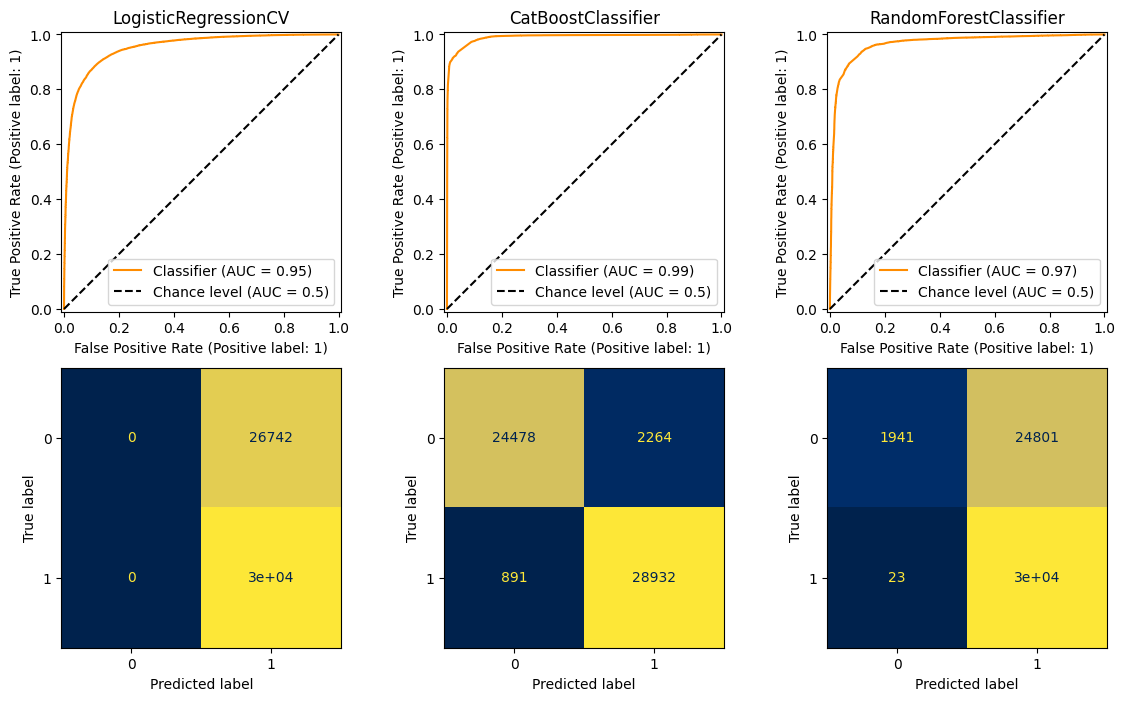

In [138]:
fig, axes = plt.subplots(2, 3)
fig.set_figwidth(14)
fig.set_figheight(8)

for model, ax in zip(rep, axes[0]):
    score = model.predict_proba(x_test)[:, 1]
    RocCurveDisplay.from_predictions(
    y_test,
    score,
    color="darkorange",
    plot_chance_level=True,
    ax=ax
    )
    ax.set_title(model['model'].model.__class__.__name__)

for model, ax in zip(rep, axes[1]):
    ConfusionMatrixDisplay.from_estimator(model, x_test, y_test, ax=ax, colorbar=False, cmap='cividis')

Исходя из приведенных графиков и метрик, очевидно заметно преимущество catboost классификатора. он смог выдержать баланс между всеми метриками, не предаваясь одному только recall. Остальные 2 модели слишком сильно ударились в оптимизацию именно этого параметра, в результате чего получился дисбаланс. Модели просто предсказывают практически всегда 1 класс, чем повышают recall. Точность на них слишком мала, чтобы их можно было выбрать в качестве финального варианта модели.

Однако если сравнить метрики моделей до и после оптимизации, можно заметить, что до оптимизации параметры были заметно лучше для логистической регрессии и случайного леса, слегка лучше для бустинга. Таким образом, необходимо сравнить метрики бустинга после оптимизации и всех 3 моделей до нее. 

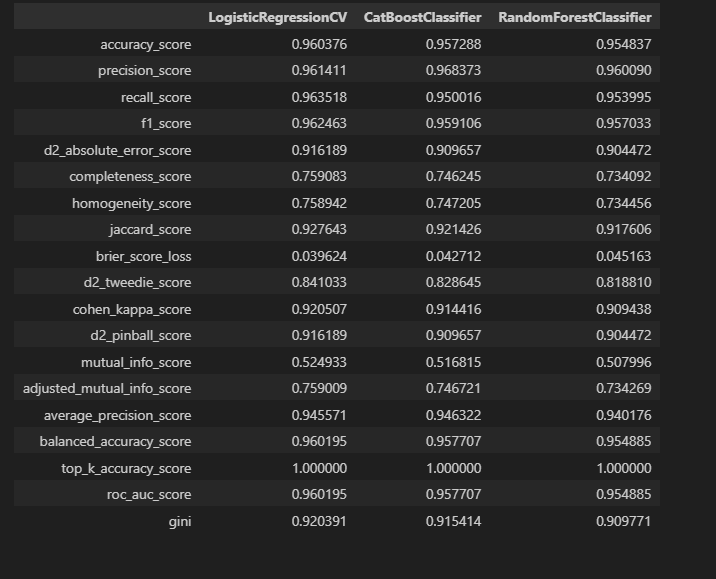 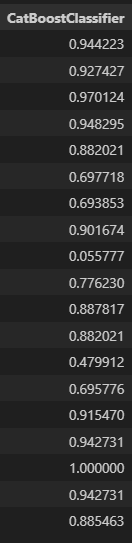

После анализа метрик, становится понятно, что лучшая модель - LogisticRegressionCV. Выбираю ее в качестве финальной модели. Ее необходимо протестировать на внешних данный, чтобы убедиться в правильности выбора конечного эстиматора.

In [15]:
with open('vectorizers/vect_no_stem_text.pickle', 'rb') as handle:
    vectorizer_no_stem = pickle.load(handle)

In [13]:
x_train, _, y_train, _ = train_test_split(full_df.no_stem_text, full_df.emotion, test_size=0.15, random_state=42, stratify=full_df.emotion)

In [16]:
x_train_vect = vectorizer_no_stem.transform(x_train)

In [17]:
model = LogisticRegressionCV(n_jobs=-1)
model.fit(x_train_vect, y_train)

LogisticRegressionCV(n_jobs=-1)

In [18]:
final_model = Pipeline([
    ('tfindf', vectorizer_no_stem),
    ('model', model)
])

#### Тест модели на внешних данных

In [19]:
messages = np.array([
    "Your service was terrible; I didn't expect this from a bank!",
    "I am extremely dissatisfied with how you handled my request—it's simply appalling!",
    "It was unpleasant when I wasn't provided with the necessary information.",
    "I can't believe your team made such awful mistakes on my account—this is just unacceptable!",
    "This isn't what I expected and now i'm disappointed",
    "I am very impressed with the excellent service I received! Thanks a million!",
    "Your team was incredibly helpful and resolved my issue quickly—thank you!",
    "I appreciate the prompt response and the thoroughness of your support.",
    "The staff went above and beyond to ensure my satisfaction—fantastic job!",
    "I had a wonderful experience with your service; I will definitely recommend you!"
])
true_labels = [0] * 5 + [1] * 5

In [22]:
probs = final_model.predict_proba(messages)
for i, proba in enumerate(probs):
    print(f"{i+1}) {'true' if np.argmax(proba) == true_labels[i] else 'false'} predict: {'good' if np.argmax(proba) == 1 else 'bad'} mood with the probability of {max(proba)}")

1) true predict: bad mood with the probability of 0.9958163016345046
2) true predict: bad mood with the probability of 0.833769688608466
3) true predict: bad mood with the probability of 0.997793661698861
4) true predict: bad mood with the probability of 0.9902298548550202
5) true predict: bad mood with the probability of 0.9998158054731593
6) true predict: good mood with the probability of 0.8633255738933809
7) true predict: good mood with the probability of 0.9963913312839369
8) true predict: good mood with the probability of 0.6283746881297644
9) true predict: good mood with the probability of 0.9667292595690248
10) true predict: good mood with the probability of 0.9688475231773832


### Сохранение конечного варианта модели

In [21]:
with open('result_model_pileline.pickle', 'wb') as handle:
    pickle.dump(final_model, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [54]:
!python test_model.py --text 'help me at'

['help me at last']: bad mood with the probability of 0.7828691983569027


### Выводы:

Была проделана большая работа сразу по нескольким пунктам:
- поиск датасета, который имеет достаточную информативность для обучения модели и необходимые параметры, такие как распределение длин текстов и лейблов
- анализ найденных датасетов и выделение лучшего. В данной работе представлен уже конечный, выбранный мной, лучший датасет
-  подготовка и предобработка данных, которая включает в себя очистку от ненужных символов, выдвижение гипотезы про стемминг и лемматизацию
-  обучение сразу нескольких моделей для нахождения лучшего варианта
-  выделение лучших моделей, обученных на изначальных параметрах. подбор для них оптимальных параметров
-  выделение лучшей модели среди прооптимизированной тройки лидеров
-  проверка на независимых примерах
  
В результате была достигнута главная цель работы - получение оптимальной модели для бинарной классификации эмоций человека по текстовым сообщениям